In [12]:
import sys
sys.path.append('../10_utils/')
import colorDict

age_color_dict = colorDict.age_color_dict()
tissue_color_dict = colorDict.tissue_color_dict()
methods_color_dict = colorDict.method_color_dict()



plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(10,10) #rescale figures
sc.settings.set_figure_params(dpi=50)

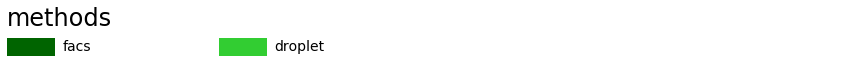

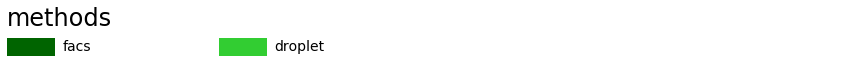

In [2]:
colorDict.plot_colortable(methods_color_dict,'methods')

In [50]:
set(adata.obs['tissue'])

{'Aorta',
 'BAT',
 'Bladder',
 'Brain_Myeloid',
 'Brain_Non-Myeloid',
 'Diaphragm',
 'Fat',
 'GAT',
 'Heart',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'MAT',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'SCAT',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

In [4]:
import sys
sys.path.append('../../../../src/scVI/')
import scvi
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE, SCANVI
from scvi.dataset.anndataset import AnnDatasetFromAnnData

[2020-01-22 21:22:49,896] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/angela/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [5]:
scvi.__version__ 

'0.5.0'

In [3]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [7]:
torch.cuda.is_available()

True

In [8]:
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from typing import Tuple

In [9]:
from scvi.dataset import AnnDatasetFromAnnData

In [10]:
pwd

'/home/angela/maca/tabula-muris-senis/1_tabula_muris_senis/11_figure_1'

In [11]:
adata_droplet = sc.read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-droplet-official-raw-obj.h5ad')
display(adata_droplet)

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [12]:
adata_droplet#.obs['cell_ontology_class'] = adata_droplet.obs['cell_ontology_class_reannotated']

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [13]:
# adata_droplet.obs = adata_droplet.obs.drop(
#     ['batch', 'cell', 'cell_ontology_class_reannotated', 'n_genes','tissue_free_annotation'],axis=1)
# adata_droplet

In [14]:
adata_facs = sc.read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-facs-official-raw-obj.h5ad')
display(adata_facs)

AnnData object with n_obs × n_vars = 110824 × 22966 
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [15]:
adata_facs.obs = adata_facs.obs.drop(['FACS.selection','cell'],axis=1)
adata_facs

AnnData object with n_obs × n_vars = 110824 × 22966 
    obs: 'age', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [16]:
adata = adata_droplet.concatenate(adata_facs)

In [17]:
sum(adata.obs.batch=='0'),sum(adata.obs.batch=='1')

(245389, 110824)

In [18]:
adata.raw = adata
print('normalization & scaling')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                          min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                          log=True, copy=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10, zero_center=False)
adata.uns['tissue_colors'] = list(tissue_color_dict.values())


print('pca')
sc.tl.pca(adata,svd_solver='arpack')
sc.pl.pca_overview(adata)


print('neighs')
sc.external.pp.bbknn(adata, 
                      batch_key='batch', 
                      approx=True, metric='angular',
                      n_pcs=50, trim=None, n_trees=10, 
                      use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=1)
adata

normalization & scaling
normalizing by total count per cell
    finished (0:00:13): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:04)
pca
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:28)


... storing 'age' as categorical
... storing 'cell' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_free_annotation' as categorical


neighs
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:31)


AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'log1p', 'tissue_colors', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'

... storing 'tissue' as categorical


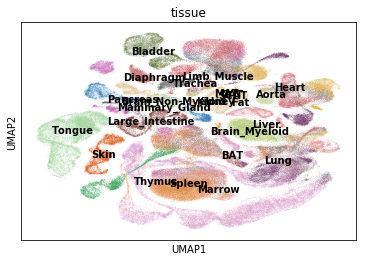

In [53]:
# adata.obs.loc[adata.obs['tissue'] == 'Heart_and_Aorta','tissue'] = 'Heart'
adata.uns['tissue_colors'] = list(tissue_color_dict.values())

sc.pl.umap(adata,color=['tissue'], legend_loc='on data')

In [43]:
print('umap computing')
sc.tl.umap(adata,n_components=2)
adata.obs['tissue_FACS_droplet'] = adata.obs['tissue'].copy()
adata.obs.loc[adata.obs['tissue'] == 'Heart_and_Aorta','tissue'] = 'Heart'
adata.obs['tissue'] = adata.obs['tissue'].astype(str)
adata.uns['age_colors'] = list(age_color_dict.values())
adata.uns['tissue_colors'] = list(tissue_color_dict.values())
adata.uns['method_colors'] = list(methods_color_dict.values())
sc.pl.umap(adata,color='tissue')#,projection='3d',save='_maca_facs_3d_tissue.pdf')
sc.pl.umap(adata,color='age')#,projection='3d', save='_maca_facs_3d_age.pdf')

print('clustering')
sc.tl.louvain(adata)#, resolution = 5)
sc.tl.leiden(adata)#, resolution = 5)

sc.pl.umap(adata,color=['louvain'], legend_loc='on data')

... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'louvain' as categorical


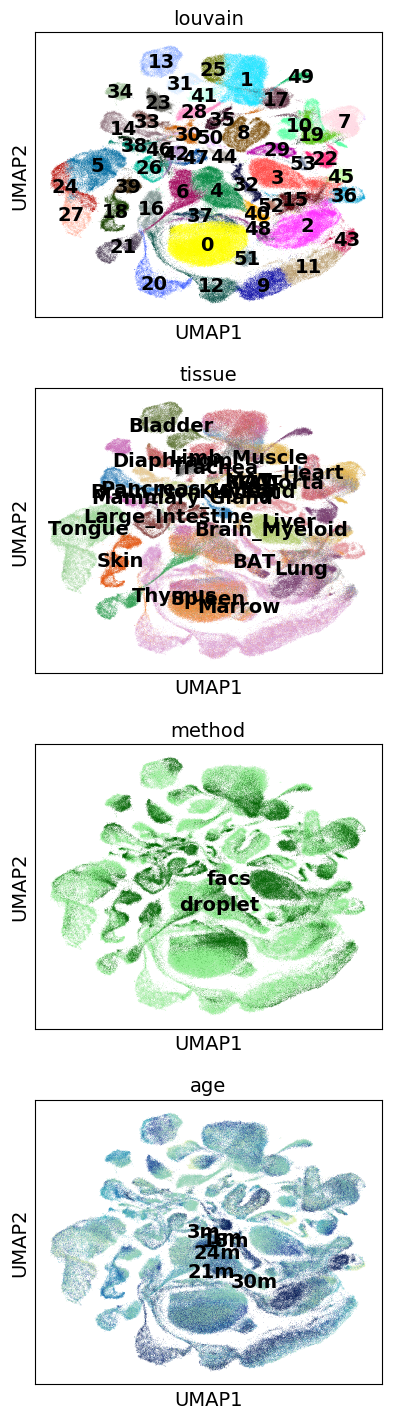

In [50]:
sc.pl.umap(adata,color=['louvain','tissue','method','age'], legend_loc='on data',ncols=1)

In [55]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain', 'leiden'
    var: 'n_cells-0', 'n_cells-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'log1p', 'tissue_colors', 'pca', 'neighbors', 'umap', 'age_colors', 'louvain', 'leiden', 'louvain_colors', 'method_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [42]:
adata.write('./tms-all-bbknn.h5ad')

... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'louvain' as categorical


In [4]:
adata = sc.read_h5ad('./tms-all-bbknn.h5ad')
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain', 'leiden'
    var: 'n_cells-0', 'n_cells-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'leiden', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [49]:
adata.uns['method_colors']

['#90ee90', '#006400']

In [51]:
adata.write('../../0_data_ingest/01_figure_1/tabula-muris-senis-bbknn-processed-official-annotations.h5ad')

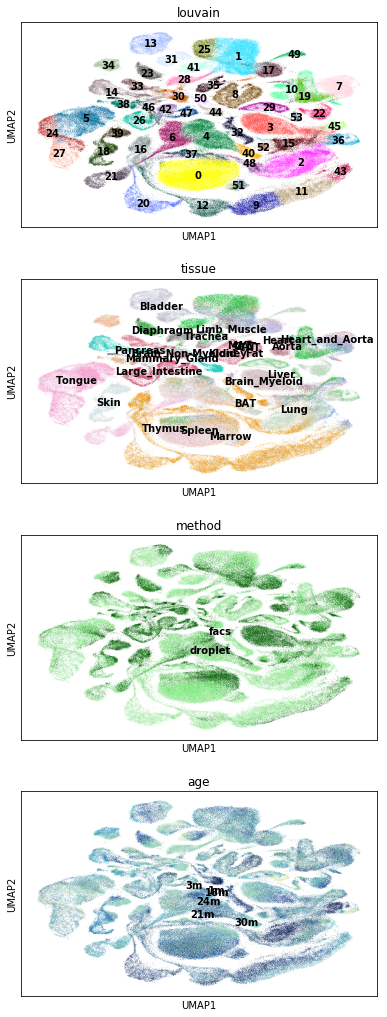

In [9]:
sc.pl.umap(adata,color=['louvain','tissue','method','age'], legend_loc='on data',ncols=1)

... storing 'tissue' as categorical


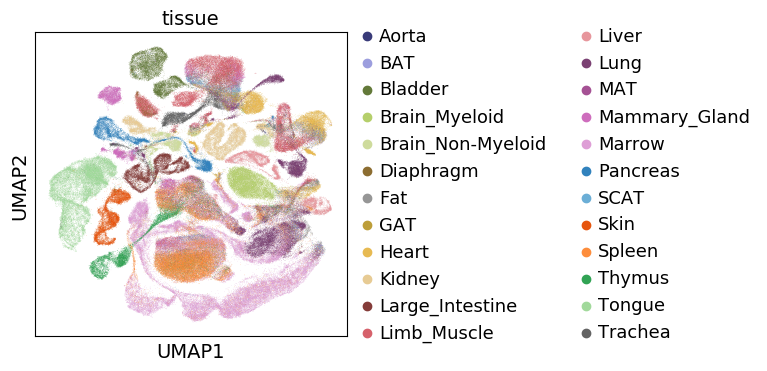

In [15]:
adata.obs['tissue_FACS_droplet'] = adata.obs['tissue'].copy()
adata.obs.loc[adata.obs['tissue'] == 'Heart_and_Aorta','tissue'] = 'Heart'
adata.obs['tissue'] = adata.obs['tissue'].astype(str)
adata.uns['tissue_colors'] = list(tissue_color_dict.values())

sc.pl.umap(adata,color=['tissue'])

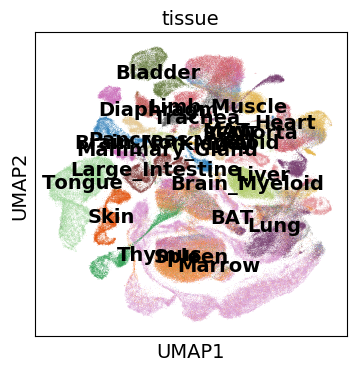

In [16]:
# sc.pl.umap(adata,color=['louvain'], legend_loc='on data',ncols=1, save='_bbknn_louvain.pdf')
sc.pl.umap(adata,color=['tissue'], legend_loc='on data',ncols=1, save='_bbknn_tissue.pdf')
# sc.pl.umap(adata,color=['method'],ncols=1, save='_bbknn_method.pdf')
# sc.pl.umap(adata,color=['age'],ncols=1, save='_bbknn_age.pdf')

In [53]:
adata.obs['louvain'] = adata.obs['louvain'].astype(str)
adata.obs['tissue'] = adata.obs['tissue'].astype(str)
adata.obs['mouse.id'] = adata.obs['mouse.id'].astype(str)
adata.obs['method'] = adata.obs['method'].astype(str)
adata.obs['age'] = adata.obs['age'].astype(str)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs['cell_ontology_class'] = adata.obs['cell_ontology_class'].astype(str)

endothelial_dataframe = adata[adata.obs['cell_ontology_class'].isin(
    ['endothelial cell','endothelial cell of coronary artery','endothelial cell of hepatic sinusoid','endothelial cell of lymphatic vessel','aortic endothelial cell'])].obs#,'immature B cell','precursor B cell','early pro-B cell','late pro-B cell'])].obs
# endothelial_dataframe = adata[adata.obs['cell_ontology_class'].isin(
#     ['B cell','naive B cell'])].obs#

endothelial_dataframe = endothelial_dataframe[~endothelial_dataframe['tissue'].isin(['Brain_Myeloid','Brain_Non-Myeloid'])]

display(endothelial_dataframe.shape)

endothelial_dataframe_grouped = endothelial_dataframe.groupby(['louvain','method'])['mouse.id'].agg({'cells':len})#,'age'
endothelial_dataframe_grouped#.loc[('1','24m')]

endothelial_dataframe_grouped.reset_index(inplace=True)
endothelial_dataframe_grouped

pivot_df_endothelials = endothelial_dataframe_grouped.pivot_table(columns=['louvain'], index=['method'], values='cells') #,'age'
# pivot_df_endothelials = endothelial_dataframe_grouped.pivot_table(columns=['louvain_scvi'], index=['tissue'], values='cells') #,'age'
# pivot_df_endothelials[pivot_df_endothelials<10]=np.nan
# pivot_df_endothelials = pivot_df_endothelials.dropna(thresh=1)

pivot_df_endothelials['sum'] = pivot_df_endothelials.sum(axis=1)
pivot_df_endothelials['%'] = pivot_df_endothelials['sum']/endothelial_dataframe.shape[0]*100
pivot_df_endothelials = pivot_df_endothelials.replace(np.nan,0)
pivot_df_endothelials = pivot_df_endothelials.sort_values(by='%',ascending=False)
pivot_df_endothelials = pivot_df_endothelials.div(pivot_df_endothelials['sum'],axis=0)
pivot_df_endothelials = pivot_df_endothelials.drop(['sum','%'],axis=1)
pivot_df_endothelials.loc['sum'] = pivot_df_endothelials.sum(axis=0)
# pivot_df_endothelials = pivot_df_endothelials.iloc[:,list(pivot_df_endothelials.loc['sum']>.01)]
pivot_df_endothelials = pivot_df_endothelials.drop(['sum'],axis=0)
pivot_df_endothelials



(20476, 17)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



louvain,0,1,10,11,12,13,14,15,16,17,...,45,46,47,5,50,51,53,6,7,9
method,,,,,,,,,,,,,,,,,,,,,
droplet,0.000000,0.000863,0.165072,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000072,0.000000,0.000000,0.000575,0.000000,0.046824,0.000000,0.376466,0.000000
facs,0.002586,0.001826,0.120645,0.000456,0.001826,0.001065,0.000456,0.001978,0.00213,0.001369,...,0.000304,0.014757,0.000304,0.000152,0.001826,0.000456,0.094934,0.001521,0.640195,0.000609


In [45]:
pivot_df_endothelials.columns

Index(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '22', '23', '25', '28', '29', '3', '30', '31', '32', '34', '35', '36',
       '39', '4', '43', '44', '45', '46', '47', '5', '50', '51', '53', '6',
       '7', '9'],
      dtype='object', name='louvain')

/home/angela/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


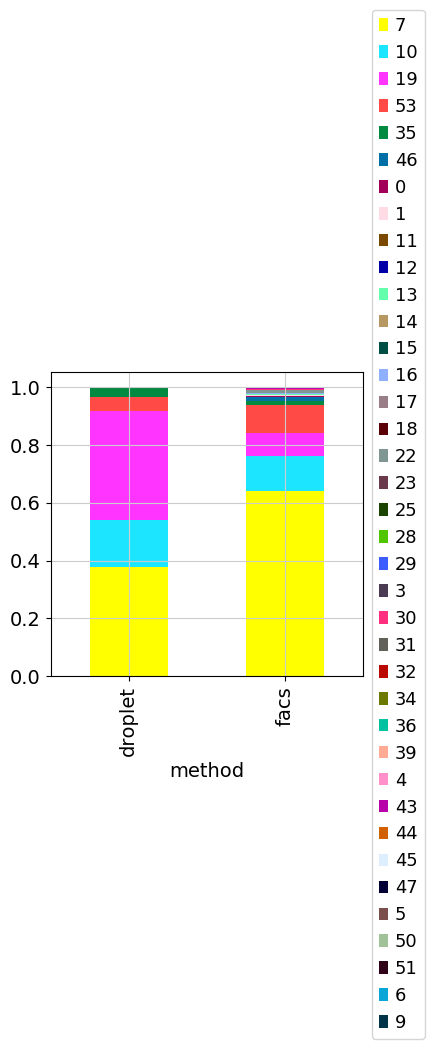

In [47]:
f = plt.figure()
order = ['7','10','19','53','35','46',
         '0', '1',  '11', '12', '13', '14', '15', '16', '17', '18', 
       '22', '23', '25', '28', '29', '3', '30', '31', '32', '34','36',
       '39', '4', '43', '44', '45',  '47', '5', '50', '51',  '6','9']
pivot_df_endothelials[order].plot(kind='bar', stacked=True, ax=f.gca(), color=adata.uns['louvain_colors'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.show()
plt.tight_layout()
plt.savefig('endothelial_cells_method.pdf')

(39706, 17)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


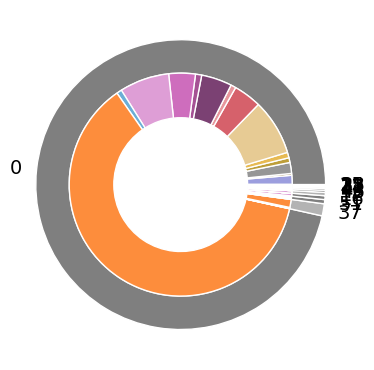

In [124]:
bcell_dataframe = adata[adata.obs['cell_ontology_class'].isin(
    ['B cell','naive B cell'])].obs#,'immature B cell','precursor B cell','early pro-B cell','late pro-B cell'])].obs
display(bcell_dataframe.shape)

bcell_dataframe_grouped = bcell_dataframe.groupby(['louvain','tissue'])['mouse.id'].agg({'cells':len})#,'age'
bcell_dataframe_grouped#.loc[('1','24m')]

bcell_dataframe_grouped.reset_index(inplace=True)
bcell_dataframe_grouped

# pivot_df_bcells = bcell_dataframe_grouped.pivot_table(index=['louvain'], columns=['tissue','age'], values='cells') #,'age'
pivot_df_bcells = bcell_dataframe_grouped.pivot_table(index=['louvain'], columns=['tissue'], values='cells') #,'age'
pivot_df_bcells[pivot_df_bcells<10]=np.nan
pivot_df_bcells = pivot_df_bcells.dropna(thresh=1)

pivot_df_bcells['sum'] = pivot_df_bcells.sum(axis=1)
pivot_df_bcells['%'] = pivot_df_bcells['sum']/bcell_dataframe.shape[0]*100
pivot_df_bcells = pivot_df_bcells.replace(np.nan,0)
pivot_df_bcells = pivot_df_bcells.sort_values(by='%',ascending=False)
pivot_df_bcells#[pivot_df_bcells>0]=2

 # Make data: I have 3 groups and 7 subgroups
group_names=pivot_df_bcells.index
group_size=pivot_df_bcells['sum']

subgroupNames = pd.DataFrame([pivot_df_bcells.drop(['sum','%'],axis=1).columns.values]*pivot_df_bcells.shape[0]).values
subgroup_names = []
for x in subgroupNames:
    for y in x:
        subgroup_names.append(y)

subgroup_size = pivot_df_bcells.drop(['sum','%'],axis=1).to_numpy().flatten()

# Create colors
a, b, c=[plt.cm.binary, plt.cm.binary, plt.cm.binary]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.5), b(0.3), c(0.5)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3,
                   colors=[tissue_color_dict[x] for x in subgroup_names])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.savefig('./figures/shared-cell-types_B-cell_naive-B-cell_bbknn.pdf')
plt.show()

(22708, 17)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


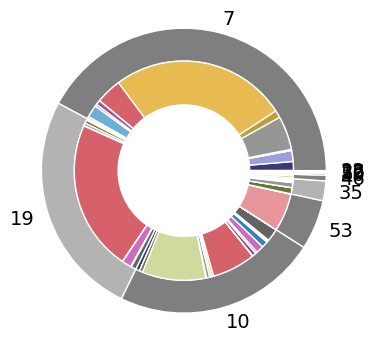

In [126]:
endothelial_dataframe = adata[adata.obs['cell_ontology_class'].isin(
    ['endothelial cell','endothelial cell of coronary artery','endothelial cell of hepatic sinusoid','endothelial cell of lymphatic vessel','aortic endothelial cell'])].obs#,'immature B cell','precursor B cell','early pro-B cell','late pro-B cell'])].obs
display(endothelial_dataframe.shape)

endothelial_dataframe_grouped = endothelial_dataframe.groupby(['louvain','tissue'])['mouse.id'].agg({'cells':len})#,'age'
endothelial_dataframe_grouped#.loc[('1','24m')]

endothelial_dataframe_grouped.reset_index(inplace=True)
endothelial_dataframe_grouped

# pivot_df_endothelials = endothelial_dataframe_grouped.pivot_table(index=['louvain'], columns=['tissue','age'], values='cells') #,'age'
pivot_df_endothelials = endothelial_dataframe_grouped.pivot_table(index=['louvain'], columns=['tissue'], values='cells') #,'age'
pivot_df_endothelials[pivot_df_endothelials<10]=np.nan
pivot_df_endothelials = pivot_df_endothelials.dropna(thresh=1)

pivot_df_endothelials['sum'] = pivot_df_endothelials.sum(axis=1)
pivot_df_endothelials['%'] = pivot_df_endothelials['sum']/endothelial_dataframe.shape[0]*100
pivot_df_endothelials = pivot_df_endothelials.replace(np.nan,0)
pivot_df_endothelials = pivot_df_endothelials.sort_values(by='%',ascending=False)
pivot_df_endothelials#[pivot_df_endothelials>0]=2

 # Make data: I have 3 groups and 7 subgroups
group_names=pivot_df_endothelials.index
group_size=pivot_df_endothelials['sum']

subgroupNames = pd.DataFrame([pivot_df_endothelials.drop(['sum','%'],axis=1).columns.values]*pivot_df_endothelials.shape[0]).values
subgroup_names = []
for x in subgroupNames:
    for y in x:
        subgroup_names.append(y)

subgroup_size = pivot_df_endothelials.drop(['sum','%'],axis=1).to_numpy().flatten()

# Create colors
a, b, c=[plt.cm.binary, plt.cm.binary, plt.cm.binary]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.5), b(0.3), c(0.5)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3,
                   colors=[tissue_color_dict[x] for x in subgroup_names])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.savefig('./figures/shared-cell-types_endothelial-cell_bbknn.pdf')
plt.show()

In [127]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain', 'leiden', 'tissue_FACS_droplet'
    var: 'n_cells-0', 'n_cells-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'leiden', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [130]:
import xlsxwriter
adata.obs['louvain'] = adata.obs['louvain'].astype(int)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('SupplementaryTable3_Global_Summary.xlsx', engine='xlsxwriter')

df = adata.obs.groupby(['age','sex','mouse.id','tissue'])['age'].agg({'len':len})
df.to_excel(writer, sheet_name='a')

df = adata.obs.groupby(['tissue','cell_ontology_class','age'])['age'].agg({'len':len})
df.to_excel(writer, sheet_name='b')

df = adata.obs.groupby(['louvain','cell_ontology_class','tissue','age'])['age'].agg({'len':len})
df.to_excel(writer, sheet_name='c')

df = adata.obs.groupby(['cell_ontology_class','louvain','tissue','age'])['age'].agg({'len':len})
df.to_excel(writer, sheet_name='d')

df = adata.obs.groupby(['cell_ontology_class','tissue','louvain'])['age'].agg({'len':len})
df = df.unstack('louvain')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='cell-type_organ_louvain-number')


df = adata.obs.groupby(['louvain','tissue'])['age'].agg({'len':len})
df = df.unstack('tissue')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='organ_louvain-number')


df = adata.obs.groupby(['louvain','cell_ontology_class'])['age'].agg({'len':len})
df = df.unstack('cell_ontology_class')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='louvain-number_cell-type')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  import sys
/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we load stuff.
/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  del sys.path[0]
/home/angela/anaconda3/lib/python3.7/site-packages/ipyk

In [18]:
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from typing import Tuple


def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 10,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space
    
    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata,batch_label = 'batch')

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_hidden=128, n_latent=30, n_layers=5, dispersion='gene'
    )
    trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####
    
    torch.save(trainer.model.state_dict(), 'tms-scVI-trainer-model')

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent


In [19]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'

In [20]:
n_epochs_all = None
n_epochs = 100 if n_epochs_all is None else n_epochs_all

scvi_posterior, scvi_latent = compute_scvi_latent(
    adata, n_epochs=n_epochs, n_latent=6,
    use_batches = True, use_cuda=True
)
adata.obsm["X_scvi"] = scvi_latent

[2020-01-11 11:50:34,967] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-11 11:50:34,978] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-11 11:50:38,110] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-11 11:50:41,200] INFO - scvi.dataset.dataset | Downsampled from 356213 to 356213 cells


training: 100%|██████████| 100/100 [1:57:05<00:00, 70.25s/it]


In [23]:
adata.write('tms-scVI-adata.h5ad')

... storing 'age' as categorical
... storing 'cell' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_free_annotation' as categorical


In [ ]:
trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)
trainer.model.load_state_dict(torch.load('tms-scVI-trainer-model'))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv

sc.settings.verbosity = 3
sc.logging.print_versions()
np.random.seed(685)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.set_figure_params(dpi=50)

In [ ]:
# adata = read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-scVI-official-annotations-umap.h5ad')
adata = read_h5ad('../../../tabula-muris-senis-scVI-official-annotations.h5ad')
adata

computing PCA with n_comps = 50
    finished (0:02:23.92)


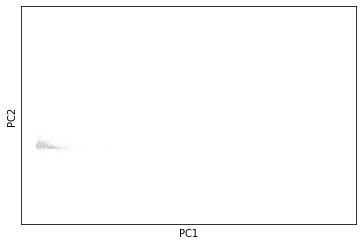

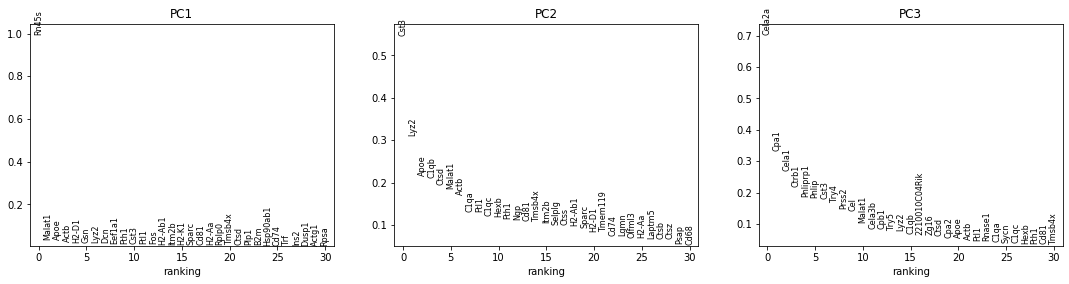

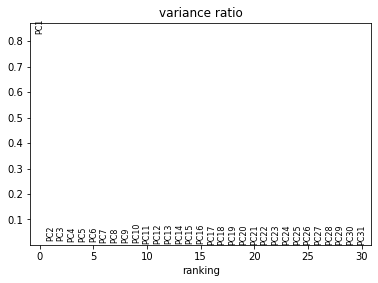

In [24]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_overview(adata)

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scvi", n_pcs=80)#, n_neighbors=15
sc.tl.umap(adata)

computing neighbors


/home/angela/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:01:23.50) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


In [ ]:
sc.tl.louvain(adata, key_added="louvain_scvi")#, resolution=2)

In [27]:
adata.obs[adata.obs['cell_ontology_class']=='B cell']

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi
AAACGGGGTAAGTTCC-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAACGGGGTAAGTTCC,B cell,NA,B cell,droplet,18-F-50,NaN,1966.0,female,nan,Mammary_Gland,Mammary_Gland,35
AAACGGGTCGAATGGG-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAACGGGTCGAATGGG,B cell,NA,B cell,droplet,18-F-50,NaN,1252.0,female,nan,Mammary_Gland,Mammary_Gland,43
AACTCAGCAGGTCCAC-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AACTCAGCAGGTCCAC,B cell,NA,B cell,droplet,18-F-50,NaN,1056.0,female,nan,Mammary_Gland,Mammary_Gland,10
AAGTCTGGTTCGTGAT-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAGTCTGGTTCGTGAT,B cell,NA,B cell,droplet,18-F-50,NaN,1018.0,female,nan,Mammary_Gland,Mammary_Gland,35
ACGATGTGTAAGGATT-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_ACGATGTGTAAGGATT,B cell,NA,B cell,droplet,18-F-50,NaN,1331.0,female,nan,Mammary_Gland,Mammary_Gland,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA000531.3_8_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_8_M,231316.0,1489.0,male,Fat,MAT,nan,0
P9.MAA000559.3_8_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,CD79a B cell,facs,3_8_M,410087.0,1780.0,male,nan,Spleen,nan,0
P9.MAA000877.3_11_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_11_M,608430.0,2375.0,male,Fat,MAT,nan,8
P9.MAA000914.3_9_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_9_M,338307.0,1330.0,male,Fat,MAT,nan,35


In [254]:
tissue_color_dict

{'Bladder': '#393b79',
 'Brain_Myeloid': '#393b79',
 'Brain_Non-Myeloid': '#5254a3',
 'Fat': '#6b6ecf',
 'Heart_and_Aorta': '#9c9ede',
 'Kidney': '#637939',
 'Large_Intestine': '#8ca252',
 'Limb_Muscle': '#b5cf6b',
 'Liver': '#cedb9c',
 'Lung': '#8c6d31',
 'Mammary_Gland': '#bd9e39',
 'Marrow': '#e7ba52',
 'Pancreas': '#e7ba52',
 'Skin': '#e7cb94',
 'Spleen': '#843c39',
 'Thymus': '#ad494a',
 'Tongue': '#d6616b',
 'Trachea': '#e7969c',
 'BAT': '#7b4173',
 'GAT': '#a55194',
 'MAT': '#ce6dbd',
 'SCAT': '#de9ed6'}

In [255]:
set(adata.obs['tissue'])

{'Aorta',
 'BAT',
 'Bladder',
 'Brain_Myeloid',
 'Brain_Non-Myeloid',
 'Diaphragm',
 'Fat',
 'GAT',
 'Heart',
 'Heart_and_Aorta',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'MAT',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'SCAT',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

In [252]:
adata_nonans.uns['tissue_colors'] = list(maca_color_dict.values())

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [ ]:
sc.pl.umap(adata,color=['tissue','method','age'],ncols=1)

In [ ]:
adata

In [ ]:
len(set(adata.obs['louvain_scvi']))

In [506]:
bcells = adata[adata.obs['cell_ontology_class']=='B cell'].copy()
bcells

AnnData object with n_obs × n_vars = 36349 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

computing PCA with n_comps = 50


... storing 'cell_ontology_class' as categorical
... storing 'louvain_scvi' as categorical


    finished (0:00:15.70)


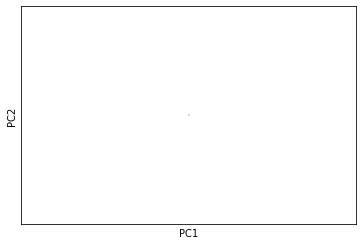

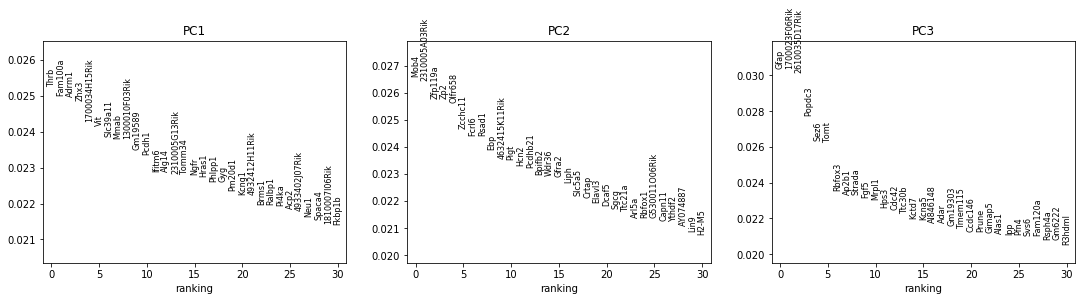

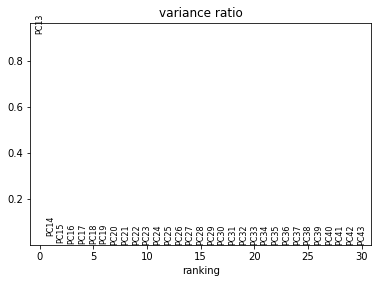

computing neighbors


/home/angela/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:09.75) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:34.77) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:06.19) --> found 14 clusters and added
    'louvain_scvi', the cluster labels (adata.obs, categorical)


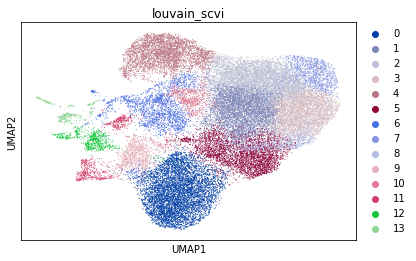

In [507]:
sc.tl.pca(bcells, svd_solver="arpack")
sc.pl.pca_overview(bcells)
sc.pp.neighbors(bcells, n_neighbors=20, n_pcs=40, use_rep="X_scvi")
sc.tl.umap(bcells)
sc.tl.louvain(bcells, key_added="louvain_scvi", resolution=0.7)
sc.pl.umap(bcells,color='louvain_scvi')

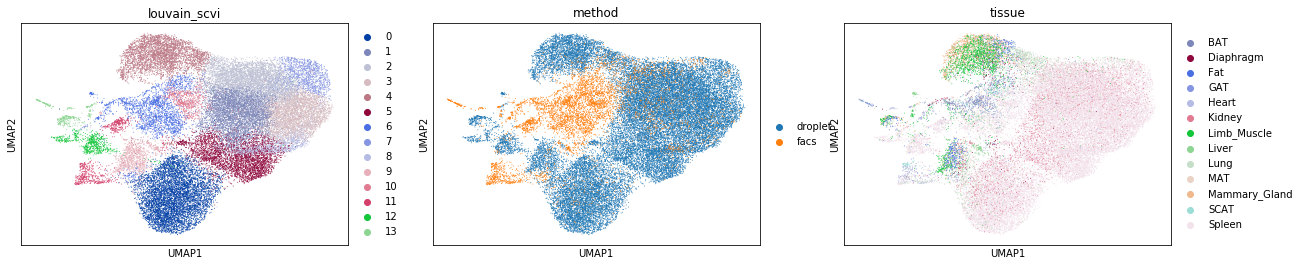

In [508]:
sc.pl.umap(bcells,color=['louvain_scvi','method','tissue'])

In [519]:
bcells.obs['louvain_scvi'] = bcells.obs['louvain_scvi'].astype(str)
bcells.obs['tissue'] = bcells.obs['tissue'].astype(str)
bcells.obs['mouse.id'] = bcells.obs['mouse.id'].astype(str)
bcells.obs['age'] = bcells.obs['age'].astype(str)
bcells.obs['sex'] = bcells.obs['sex'].astype(str)
#bcells.obs['cell_ontology_class'] = adata.obs['cell_ontology_class_reannotated'].astype(str)


bcells_metadata = bcells.obs[bcells.obs['age'].isin(['3m','18m','24m'])]
bcells_metadata = bcells_metadata[bcells_metadata['tissue'].isin(['Spleen','Mammary_Gland','Lung','Liver','Limb_Muscle','Kidney'])]

df = bcells_metadata.groupby(
    ['tissue','louvain_scvi','method','age'])['cell'].agg({'count':len}).reset_index()#
df = df.dropna()
df.to_csv('B_cells_metadata.csv')
df

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  del sys.path[0]


,tissue,louvain_scvi,method,age,count
0,Kidney,0,droplet,18m,2.0
1,Kidney,0,droplet,24m,521.0
7,Kidney,1,droplet,24m,561.0
13,Kidney,10,droplet,24m,1.0
17,Kidney,10,facs,3m,2.0
...,...,...,...,...,...
497,Spleen,8,facs,3m,36.0
498,Spleen,9,droplet,18m,7.0
499,Spleen,9,droplet,24m,4.0
501,Spleen,9,facs,18m,5.0


In [303]:
adata.obs['louvain_scvi'] = adata.obs['louvain_scvi'].astype(str)
df = pd.crosstab(adata.obs['cell_ontology_class'],adata.obs['louvain_scvi'])
df['sum'] = df.sum(axis=1)
df = df.div(df['sum'],axis=0)*100
df

louvain_scvi,0,1,10,11,12,13,14,15,16,17,...,46,47,48,49,5,6,7,8,9,sum
cell_ontology_class,,,,,,,,,,,,,,,,,,,,,
B cell,59.206581,0.002751,23.356901,0.0,0.038516,0.011004,0.013756,0.019258,0.000000,0.14856,...,0.005502,0.008253,0.0,0.002751,0.002751,0.088035,0.000000,0.030262,0.038516,100.0
Bergmann glial cell,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
Brush cell of epithelium proper of large intestine,0.000000,0.000000,0.000000,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
"CD4-positive, alpha-beta T cell",0.232423,0.000000,0.406740,0.0,0.000000,0.000000,0.000000,0.058106,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.058106,0.000000,0.000000,38.407902,0.174317,100.0
"CD8-positive, alpha-beta T cell",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.051546,0.0,0.000000,0.000000,0.051546,0.051546,26.391753,0.154639,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
type I pneumocyte,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
type II pneumocyte,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.369863,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
valve cell,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0


In [289]:
baux = adata[adata.obs['cell_ontology_class']=='B cell'].copy()
baux.obs['louvain_scvi'] = baux.obs['louvain_scvi'].astype(str)
baux = baux.obs.groupby(['tissue','louvain_scvi','method'])['cell'].agg({'len':len})
# baux = baux.reset_index()
baux
# sns.catplot(data = baux,
# #            row = 'tissue',
#                 x = 'louvain_scvi',
#            y= 'len',
#             hue = 'method')

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until


len
tissue louvain_scvi method       
BAT    0            droplet   NaN
                    facs     48.0
       1            droplet   NaN
                    facs      NaN
       10           droplet   NaN
...                           ...
Spleen 6            facs      NaN
       8            droplet   NaN
                    facs      2.0
       9            droplet   5.0
                    facs      1.0

[936 rows x 1 columns]

In [269]:
for t in list(set(adata.obs['tissue'])):
    baux = adata[adata.obs['tissue']==t].copy()
    display(pd.crosstab(baux.obs['louvain_scvi'],baux.obs['method']))

pd.crosstab(adata.obs['louvain_scvi'],adata.obs['method'])

method,droplet,facs
louvain_scvi,,
2,1,5
4,30,0
6,1,0
7,0,1
8,3,0
10,0,6
11,1851,8248
12,0,5
16,0,1


method,droplet,facs
louvain_scvi,,
0,16060,1562
2,1,0
3,1,0
4,4951,437
5,758,21
6,1360,38
8,2852,423
9,639,17
10,5939,251


method,droplet,facs
louvain_scvi,,
0,8,0
2,15,57
3,35,120
4,34,8
5,1,1
6,53,96
7,2,0
8,6,0
9,2,4


method,droplet,facs
louvain_scvi,,
1,20498,3693
2,1,12
4,32,0
6,136,0
7,1,0
11,3,0
12,1,23
17,0,1
19,0,1


method,facs
louvain_scvi,
0,1
2,14
3,16
4,147
6,13
7,46
8,8
10,1
12,274


method,droplet,facs
louvain_scvi,,
0,2054,27
1,0,1
2,0,67
3,0,45
4,777,345
5,3,5
6,97,34
7,0,1
8,2336,1356


method,facs
louvain_scvi,
0,1
1,1
2,174
3,441
4,15
5,1
6,63
8,1
9,4


method,facs
louvain_scvi,
0,84
2,1404
3,202
4,342
5,64
6,271
8,144
9,99
10,60


method,droplet
louvain_scvi,
0,30
1,1
2,1803
3,1252
4,398
5,297
6,669
8,199
9,898


method,droplet,facs
louvain_scvi,,
0,991,56
1,0,3
2,47,229
3,60,83
4,2927,241
5,549,118
6,444,449
7,0,1
8,475,76


method,droplet,facs
louvain_scvi,,
0,417,1313
2,1,12
4,1015,894
5,11731,2857
6,310,289
7,0,6
8,59,62
9,2666,547
10,813,637


method,facs
louvain_scvi,
0,21
1,2
2,486
3,153
4,24
5,3
6,50
8,12
9,1


method,facs
louvain_scvi,
0,16
2,241
3,2697
4,170
5,33
6,1093
7,12
8,15
9,41


method,facs
louvain_scvi,
0,49
2,231
3,411
4,122
5,233
6,39
8,79
9,225
10,25


method,droplet,facs
louvain_scvi,,
2,126,24
3,122,1
4,62,0
6,277,1
8,1,0
9,17,0
10,1,1
16,5280,1408
18,11,2


method,droplet,facs
louvain_scvi,,
1,5,32
2,2,15
3,0,3
4,63,11
5,0,1
6,12,7
7,1,0
9,0,5
11,0,3


method,facs
louvain_scvi,
2,2
4,6
5,16
6,237
7,13005
9,61
10,3
11,8
12,16


method,droplet,facs
louvain_scvi,,
0,2469,8
2,146,15
3,46,266
4,1129,71
5,257,3
6,1426,116
7,4,2
8,284,5
9,420,18


method,droplet,facs
louvain_scvi,,
0,35,35
2,10233,934
3,6484,400
4,548,88
5,107,29
6,1769,102
7,0,1
8,686,28
9,260,11


method,facs
louvain_scvi,
0,26
2,1556
3,271
4,360
5,56
6,496
7,1
8,40
9,137


method,droplet,facs
louvain_scvi,,
0,48,0
2,2702,339
3,564,21
4,1172,0
5,1,0
6,632,2
8,1869,0
9,24,0
10,182,0


method,facs
louvain_scvi,
0,95
2,1567
3,485
4,266
5,86
6,457
7,2
8,85
9,284


method,droplet,facs
louvain_scvi,,
1,0,32
2,109,1250
3,321,197
4,69,256
5,0,35
6,672,345
7,0,2
8,3,9
9,36,24


method,droplet,facs
louvain_scvi,,
0,24,30
2,9,3
3,2,0
4,528,362
5,2,28
6,242,56
7,4,3
8,19,8
9,98,89


method,droplet
louvain_scvi,
2,37
3,3661
5,74
6,822
9,106
15,1
17,8
18,2
19,2374


method,droplet,facs
louvain_scvi,,
0,22136,3324
1,20504,3764
2,15233,8637
3,12548,5812
4,13735,4165
5,13780,3590
6,8922,4254
7,12,13083
8,8792,2351


In [304]:
for t in list(set(bcells.obs['tissue'])):
    baux = bcells[bcells.obs['tissue']==t].copy()
display(pd.crosstab(bcells.obs['louvain_scvi'],bcells.obs['method']))

method,droplet,facs
louvain_scvi,,
0,6139,142
1,4855,282
2,4509,472
3,3763,156
4,3436,308
5,3529,83
6,51,2158
7,1315,71
8,1239,83


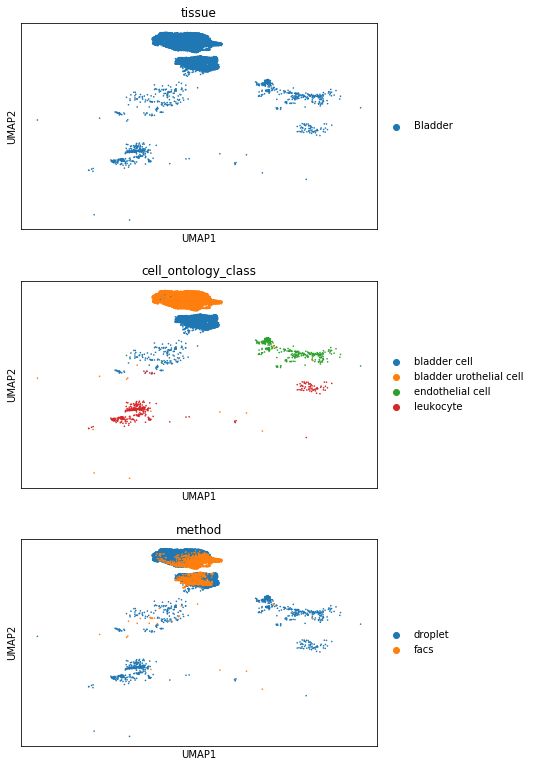

In [34]:
sc.pl.umap(adata[adata.obs['tissue'].isin(['Bladder'])],
           color=['tissue','cell_ontology_class','method'],
          ncols=1)

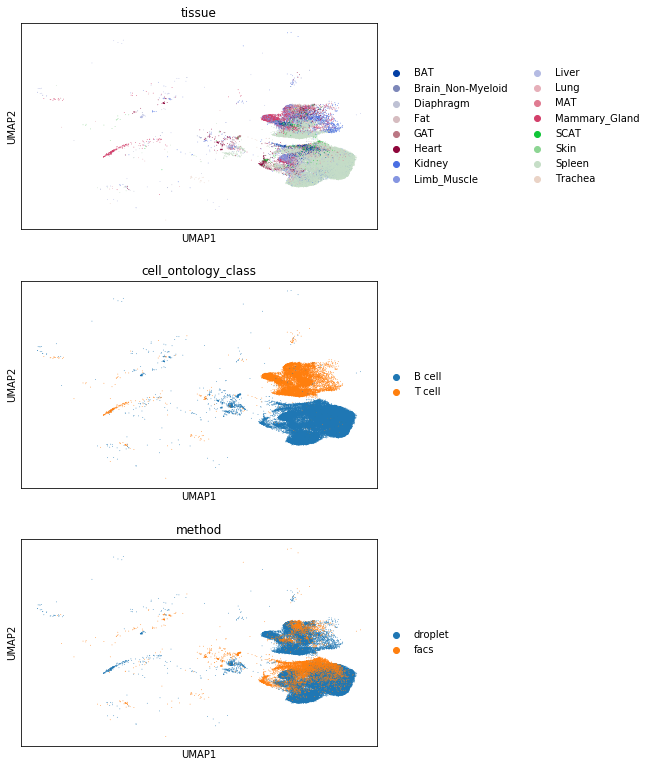

In [31]:
sc.pl.umap(adata[adata.obs['cell_ontology_class'].isin(['B cell','T cell'])],
           color=['tissue','cell_ontology_class','method'],
          ncols=1)

In [632]:
adata.obs['louvain_scvi'] = adata.obs['louvain_scvi'].astype(str)
adata.obs['tissue'] = adata.obs['tissue'].astype(str)
adata.obs['mouse.id'] = adata.obs['mouse.id'].astype(str)
adata.obs['method'] = adata.obs['method'].astype(str)
adata.obs['age'] = adata.obs['age'].astype(str)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs['cell_ontology_class'] = adata.obs['cell_ontology_class'].astype(str)

endothelial_dataframe = adata[adata.obs['cell_ontology_class'].isin(
    ['endothelial cell','endothelial cell of coronary artery','endothelial cell of hepatic sinusoid','endothelial cell of lymphatic vessel','aortic endothelial cell'])].obs#,'immature B cell','precursor B cell','early pro-B cell','late pro-B cell'])].obs
endothelial_dataframe = adata[adata.obs['cell_ontology_class'].isin(
    ['B cell'])].obs#,'naive B cell'

endothelial_dataframe = endothelial_dataframe[~endothelial_dataframe['tissue'].isin(['Brain_Myeloid','Brain_Non-Myeloid'])]

display(endothelial_dataframe.shape)

endothelial_dataframe_grouped = endothelial_dataframe.groupby(['louvain_scvi','method'])['mouse.id'].agg({'cells':len})#,'age'
endothelial_dataframe_grouped#.loc[('1','24m')]

endothelial_dataframe_grouped.reset_index(inplace=True)
endothelial_dataframe_grouped

pivot_df_endothelials = endothelial_dataframe_grouped.pivot_table(columns=['louvain_scvi'], index=['method'], values='cells') #,'age'
# pivot_df_endothelials = endothelial_dataframe_grouped.pivot_table(columns=['louvain_scvi'], index=['tissue'], values='cells') #,'age'
# pivot_df_endothelials[pivot_df_endothelials<10]=np.nan
# pivot_df_endothelials = pivot_df_endothelials.dropna(thresh=1)

pivot_df_endothelials['sum'] = pivot_df_endothelials.sum(axis=1)
pivot_df_endothelials['%'] = pivot_df_endothelials['sum']/endothelial_dataframe.shape[0]*100
pivot_df_endothelials = pivot_df_endothelials.replace(np.nan,0)
pivot_df_endothelials = pivot_df_endothelials.sort_values(by='%',ascending=False)
# pivot_df_endothelials = pivot_df_endothelials.div(pivot_df_endothelials['sum'],axis=0)
# pivot_df_endothelials = pivot_df_endothelials.drop(['sum','%'],axis=1)
pivot_df_endothelials



(36349, 17)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



louvain_scvi,0,1,10,11,12,14,15,16,18,19,...,52,53,54,55,58,59,7,8,sum,%
method,,,,,,,,,,,,,,,,,,,,,
droplet,19129.0,15.0,1.0,0.0,6240.0,3.0,5.0,27.0,3.0,1.0,...,2.0,2.0,2.0,0.0,1.0,1.0,14.0,3.0,30720.0,84.514017
facs,1209.0,3.0,8.0,3.0,723.0,2.0,1.0,17.0,0.0,14.0,...,66.0,2.0,4.0,2.0,0.0,2.0,3.0,5.0,5629.0,15.485983


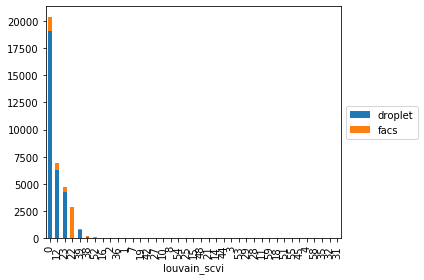

In [630]:
f = plt.figure()
pivot_df_endothelials.plot(kind='bar', stacked=True, ax=f.gca()) #, color=tissue_color_dict.values()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.show()
plt.tight_layout()
# plt.savefig('b_cells_method.pdf')

In [ ]:
sc.pl.umap(adata, color=['age'], ncols=1, save = '_tms_age.pdf')
sc.pl.umap(adata, color=['tissue'], ncols=1, save = '_tms_tissue.pdf')
sc.pl.umap(adata, color=['method'], ncols=1, save = '_tms_method.pdf')

In [259]:
adata.write('tms-scVI-adata-with-umaps.h5ad')

In [107]:
adatanorm = adata.copy()
adatanorm.raw = adatanorm

sc.pp.normalize_per_cell(adatanorm, counts_per_cell_after=1e4)
sc.pp.log1p(adatanorm)

adatanorm.write('tms-scVI-adata-normalized.h5ad')

In [106]:
senescence_adata.write('tms-scVI-adata-normalized.h5ad')

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [36]:
def rank_genes_groups_bayes(
    adata: sc.AnnData,
    scvi_posterior: scvi.inference.Posterior,
    use_observed_batches: bool = True,
    n_samples: int = None,
    M_permutation: int = None,
    n_genes: int = 25,
    label_name: str = "louvain_scvi",
) -> pd.DataFrame:
    """
    Rank genes for characterizing groups. 
    Computes Bayes factor for each cluster against the others to test for differential expression.
    See Nature article (https://rdcu.be/bdHYQ)

    :param adata: sc.AnnData object non-normalized
    :param scvi_posterior: 
    :param n_samples: 
    :param M_permutation: 
    :param n_genes: 
    :param label_name: The groups tested are taken from adata.obs[label_name] which can be computed 
                       using clustering like Louvain (Ex: sc.tl.louvain(adata, key_added=label_name) )
    :return: Summary of Bayes factor per gene, per cluster
    """

    # Call scvi function
    per_cluster_de, cluster_id = scvi_posterior.one_vs_all_degenes(
        cell_labels=np.asarray(adata.obs[label_name].values).astype(int).ravel(),
        min_cells=1,
        n_samples=n_samples,
        M_permutation=M_permutation
    )

    # convert to ScanPy format -- this is just about feeding scvi results into a format readable by ScanPy
    markers = []
    scores = []
    names = []
    for i, x in enumerate(per_cluster_de):
        subset_de = x[:n_genes]
        markers.append(subset_de)
        scores.append(tuple(subset_de["bayes1"].values))
        names.append(tuple(subset_de.index.values))

    markers = pd.concat(markers)
    dtypes_scores = [(str(i), "<f4") for i in range(len(scores))]
    dtypes_names = [(str(i), "<U50") for i in range(len(names))]
    scores = np.array([tuple(row) for row in np.array(scores).T], dtype=dtypes_scores)
    scores = scores.view(np.recarray)
    names = np.array([tuple(row) for row in np.array(names).T], dtype=dtypes_names)
    names = names.view(np.recarray)

    adata.uns["rank_genes_groups_scvi"] = {
        "params": {
            "groupby": "",
            "reference": "rest",
            "method": "",
            "use_raw": True,
            "corr_method": "",
        },
        "scores": scores,
        "names": names,
    }
    return markers

In [ ]:
adata

In [ ]:
set(adata.obs['agenum'])

In [40]:
tissuelist = list(set(adata.obs['tissue']))
tissuelist.sort()
tissuelist

['Aorta',
 'BAT',
 'Bladder',
 'Brain_Myeloid',
 'Brain_Non-Myeloid',
 'Diaphragm',
 'Fat',
 'GAT',
 'Heart',
 'Heart_and_Aorta',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'MAT',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'SCAT',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea']

In [195]:
adata.obs['age_group'] = 0
adata.obs.loc[adata.obs['age'].isin(['1m','3m']),'age_group'] = 0
adata.obs.loc[adata.obs['age'].isin(['18m','21m','24m','30m']),'age_group'] = 1

adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi,tint,age_group
AAACCTGCAGGGTACA-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,1,23,1
AAACCTGCAGTAAGCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,1,23,1
AAACCTGTCATTATCC-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,1,23,1
AAACGGGGTACAGTGG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,1,23,1
AAACGGGGTCTTCTCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,1,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_MAA001690_S20.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_54_F,146922.0,3523.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P8_MAA001700_S104.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,1027535.0,4476.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000485_S69.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_47_F,1184061.0,2980.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000492_S153.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_46_F,771128.0,2595.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1


In [198]:
adata.obs.tail()

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi,tint,age_group
P8_MAA001690_S20.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_54_F,146922.0,3523.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P8_MAA001700_S104.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,1027535.0,4476.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000485_S69.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_47_F,1184061.0,2980.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000492_S153.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_46_F,771128.0,2595.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_MAA001700_S105.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,31365.0,2520.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1


In [ ]:
import xlsxwriter
adata.obs['louvain'] = adata.obs['louvain'].astype(int)
adata.obs['tissue'] = adata.obs['tissue'].astype(str)
adata.obs['mouse.id'] = adata.obs['mouse.id'].astype(str)
adata.obs['age'] = adata.obs['age'].astype(str)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs['cell_ontology_class_reannotated'] = adata.obs['cell_ontology_class_reannotated'].astype(str)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('maca-droplet-summary.xlsx', engine='xlsxwriter')


df = adata.obs.groupby(['age','sex','mouse.id','tissue'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='droplet-summary')

df = adata.obs.groupby(['tissue','cell_ontology_class_reannotated','age'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='droplet-cell-type-summary')


df = adata.obs.groupby(['louvain','cell_ontology_class_reannotated','tissue','age'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='cluster-cell-type-tissue-age')

df = adata.obs.groupby(['cell_ontology_class_reannotated','louvain','tissue','age'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='cell-type-cluster-tissue-age')


df = adata.obs.groupby(['cell_ontology_class_reannotated','tissue','louvain'])['age'].agg({'len':len})
df = df.unstack('louvain')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='cell-type_tissue_louvain-number')

df = adata.obs.groupby(['louvain','tissue'])['age'].agg({'len':len})
df = df.unstack('tissue')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='tissue_louvain-number')

df = adata.obs.groupby(['louvain','cell_ontology_class_reannotated'])['age'].agg({'len':len})
df = df.unstack('cell_ontology_class_reannotated')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='louvain-number_cell-type')


# Close the Pandas Excel writer and output the Excel file.
writer.save()


In [217]:
scviDataset.n_batches

2

[2020-01-14 15:25:13,055] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-01-14 15:25:14,160] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-14 15:25:14,162] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-14 15:25:14,750] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-14 15:25:15,217] INFO - scvi.dataset.dataset | Downsampled from 11377 to 11377 cells


In [226]:
all_genes = len(adata.var_names)

use_batches = True
use_cuda = True

for t in ['Bladder']:#list(set(adata.obs['tissue'])):
    tiss = adata.copy()
    tiss = tiss[tiss.obs['tissue']==t].copy()
    istiss = np.where(adata.obs['tissue']==t)[0]
    
    scviDataset = AnnDatasetFromAnnData(tiss,batch_label = 'batch')
    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_hidden=128, n_latent=30, n_layers=5, dispersion='gene'
    )
    tiss_trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)

    tiss_posterior = tiss_trainer.create_posterior(scvi_posterior.model, scviDataset, indices=np.arange(len(tiss))).sequential()


    rank_genes_groups_bayes(
        tiss, tiss_posterior, label_name="age_group", n_genes=all_genes
    )
    
    result = tiss.uns['rank_genes_groups_scvi']
    groups = result['names'].dtype.names
    dge = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores']})
    

[2020-01-14 15:29:53,961] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-01-14 15:29:55,071] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-14 15:29:55,073] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-14 15:29:55,512] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-14 15:29:55,945] INFO - scvi.dataset.dataset | Downsampled from 11377 to 11377 cells


In [233]:
tiss_posterior.gene_dataset

GeneExpressionDataset object with n_cells x nb_genes = 11377 x 20116
    dataset_versions: 'norm_X'
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'local_means', 'batch_indices', 'labels'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

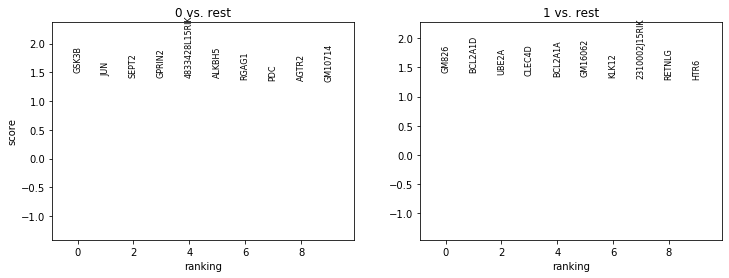

In [224]:
sc.pl.rank_genes_groups(
    tiss, key="rank_genes_groups_scvi", sharey=False, n_genes=n_genes)

In [64]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [66]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

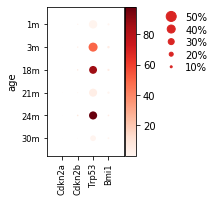

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[1.4, 0, 0.2, 0.5, 0.25])

In [72]:
sc.pl.dotplot(adata,['Cdkn2a','Cdkn2b','Trp53','Bmi1'],groupby='age')

In [103]:
np.unique(adata[:,sm].X)

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 3.7537e+04, 5.0697e+04,
       8.1945e+04], dtype=float32)

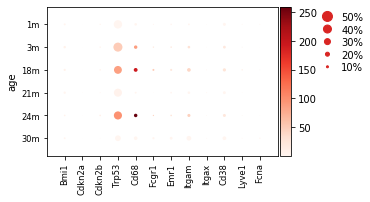

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [108]:
sc.pl.dotplot(adata, senescence_markers, groupby='age')

In [154]:
senescence_markers = ['Bmi1','Cdkn2a','Cdkn2b','Trp53',
                      'Cd68','Fcgr1','Emr1','Itgam',
                      'Itgax','Cd38','Lyve1','Fcna']
senescence = adata.obs.copy()
# senescence_adata = adata.copy()
# sc.pp.normalize_per_cell(senescence_adata, counts_per_cell_after=1e4)
# sc.pp.log1p(senescence_adata)

senescence_fractions = pd.DataFrame()

for sm in senescence_markers:
    
    senescence[sm] = senescence_adata[:,sm].X#.todense()
    senescence[sm + '_exp'] = senescence[sm].replace(0.0,np.nan)

#     dfexp = senescence.groupby(['age','tissue','mouse.id'])[sm+'_exp'].agg({'mean':np.nanmedian})
    dfexp = senescence.groupby(['age','tissue'])[sm+'_exp'].agg({'mean':np.nanmedian})
    senescence[sm] = senescence[sm].astype(bool)
    dfexp = dfexp.reset_index()
#     df = senescence.groupby(['age','tissue','mouse.id'])[sm].agg({'sum':np.sum,'len':len})
    df = senescence.groupby(['age','tissue'])[sm].agg({'sum':np.sum,'len':len})
#     df = df.reset_index()
    df['frac'] = df['sum']/df['len']
    df['mean'] = np.log(dfexp['mean'])
    
    if senescence_fractions.empty:
        senescence_fractions = pd.DataFrame(index=df.index)
    
    senescence_fractions[sm] = df['frac']

#     plt.figure()
# #     fig, ax1 = plt.subplots(1)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     sns.boxplot(x='age', y='frac', data=df, hue = 'method',
#                 order=['1m','3m','18m','21m','24m','30m'], 
# #                 palette=age_color_dict, 
#                 ax= ax1
#                )
# #     sns.swarmplot(x='age', y='frac', data=df, hue = 'method',
# #                   order=['1m','3m','18m','21m','24m','30m'], ax= ax1, color=".25")
#     ax1.set(xlabel='', ylabel='Fraction of '+ sm + '+ cells')
    
#     sns.boxplot(x='age', y='mean', data=df, hue = 'method',
#                 order=['1m','3m','18m','21m','24m','30m'], 
# #                 palette=age_color_dict, 
#                 ax= ax2)
# #     sns.swarmplot(x='age', y='mean', data=df, hue = 'method',
# #                   order=['1m','3m','18m','21m','24m','30m'], color=".25", ax= ax2)
#     ax2.set(xlabel='', ylabel= sm + ' median expression in ' + sm + '+ cells')
#     plt.tight_layout()

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future v

In [183]:
# senescence_markers = ['Bmi1','Cdkn2a','Cdkn2b','Trp53',
#                       'Cd68','Fcgr1','Emr1','Itgam',
#                       'Itgax','Cd38','Lyve1','Fcna']

# genesofinterest = ['Cdkn2a','Cdkn1a','Bcl2l2','Nfkb1','Lmnb1','Ccl2','Csf1','Serpine1','Hmgb1','Tnf',
#                    'Il6','Il12a','Il12b','Il10','Il1b','Il18','Nfkbiz','Irg1','Arg1','Retnla','Mrc1',
#                    'Mgl2','Cd36','Fabp4','Cd38','Bst1','Sirt1','Sirt2','Sirt3','Sirt4','Sirt5','Sirt6',
#                    'Sirt7','Parp1','Parp2','Parp3','Parp4','Tnks','Parp6','Tiparp','Parp8','Parp9',
#                    'Parp10','Parp11','Parp12','Zc3hav1','Parp14','Parp16','Sarm1','Nampt','Nadk',
#                    'Nt5e','Nmnat1','Nmnat2','Nmnat3','Nnmt']

# senescence_markers = list(set(senescence_markers + genesofinterest))

len(senescence_markers)

66

In [180]:
senescence_markers = ['Bmi1','Cdkn2a','Cdkn2b','Trp53',
                      'Cd68','Fcgr1','Emr1','Itgam',
                      'Itgax','Cd38','Lyve1','Fcna']

genesofinterest = ['Cdkn2a','Cdkn1a','Bcl2l2','Nfkb1','Lmnb1','Ccl2','Csf1','Serpine1','Hmgb1','Tnf',
                   'Il6','Il12a','Il12b','Il10','Il1b','Il18','Nfkbiz','Irg1','Arg1','Retnla','Mrc1',
                   'Mgl2','Cd36','Fabp4','Cd38','Bst1','Sirt1','Sirt2','Sirt3','Sirt4','Sirt5','Sirt6',
                   'Sirt7','Parp1','Parp2','Parp3','Parp4','Tnks','Parp6','Tiparp','Parp8','Parp9',
                   'Parp10','Parp11','Parp12','Zc3hav1','Parp14','Parp16','Sarm1','Nampt','Nadk',
                   'Nt5e','Nmnat1','Nmnat2','Nmnat3','Nnmt']

senescence_markers = list(set(senescence_markers + genesofinterest))

senescence = adata.obs.copy()

senescence_fractions = pd.DataFrame()

for sm in senescence_markers:
    
    senescence[sm] = senescence_adata[:,sm].X#.todense()
    senescence[sm + '_exp'] = senescence[sm].replace(0.0,np.nan)

#     dfexp = senescence.groupby(['age','tissue','mouse.id'])[sm+'_exp'].agg({'mean':np.nanmedian})
    dfexp = senescence.groupby(['age'])[sm+'_exp'].agg({'mean':np.nanmedian})
    senescence[sm] = senescence[sm].astype(bool)
    dfexp = dfexp.reset_index()
#     df = senescence.groupby(['age','tissue','mouse.id'])[sm].agg({'sum':np.sum,'len':len})
    df = senescence.groupby(['age'])[sm].agg({'sum':np.sum,'len':len})
#     df = df.reset_index()
    df['frac'] = df['sum']/df['len']
    df['mean'] = np.log(dfexp['mean'])
    
    if senescence_fractions.empty:
        senescence_fractions = pd.DataFrame(index=df.index)
    
    senescence_fractions[sm] = df['frac']

senescence_fractions
# for sm in senescence_markers:
#     plt.figure()
#     print(sm)
#     df = senescence_fractions.reset_index()
#     df = df.pivot("tissue","age", sm)
#     df = df.fillna(0)
#     ax = sns.heatmap(df, cmap="YlGnBu")

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future v

,Ccl2,Cdkn2b,Sirt6,Parp6,Serpine1,Csf1,Il12b,Cdkn2a,Trp53,Bmi1,...,Cdkn1a,Parp14,Parp4,Parp16,Il6,Mgl2,Sirt3,Parp10,Parp2,Nmnat2
age,,,,,,,,,,,,,,,,,,,,,
1m,0.141994,0.066590,0.059199,0.077021,0.127329,0.104696,0.000385,0.004580,0.419130,0.100924,...,0.462471,0.129176,0.095766,0.031409,0.098075,0.028176,0.126405,0.131717,0.138915,0.004157
3m,0.107945,0.067099,0.128995,0.088837,0.101431,0.143553,0.001731,0.004871,0.452175,0.120628,...,0.536074,0.140169,0.152985,0.052674,0.087128,0.035641,0.123680,0.102585,0.195273,0.015768
18m,0.119013,0.061216,0.139274,0.077219,0.082571,0.123259,0.001068,0.014630,0.394422,0.108603,...,0.450999,0.146660,0.129245,0.048454,0.082787,0.033163,0.112569,0.108196,0.171980,0.013436
21m,0.134506,0.047461,0.067568,0.070467,0.072656,0.131251,0.001094,0.022212,0.403244,0.114372,...,0.393260,0.120391,0.097795,0.034440,0.095060,0.031377,0.095060,0.135381,0.148758,0.006511
24m,0.126656,0.079308,0.105706,0.059181,0.070755,0.091748,0.002919,0.017555,0.406612,0.082747,...,0.416986,0.130211,0.110589,0.040283,0.104752,0.029403,0.097340,0.090607,0.156276,0.008135
30m,0.092359,0.025757,0.048155,0.047473,0.037917,0.060944,0.002066,0.013741,0.287262,0.091766,...,0.314222,0.145238,0.100711,0.030014,0.043862,0.026404,0.091156,0.089521,0.150088,0.002640


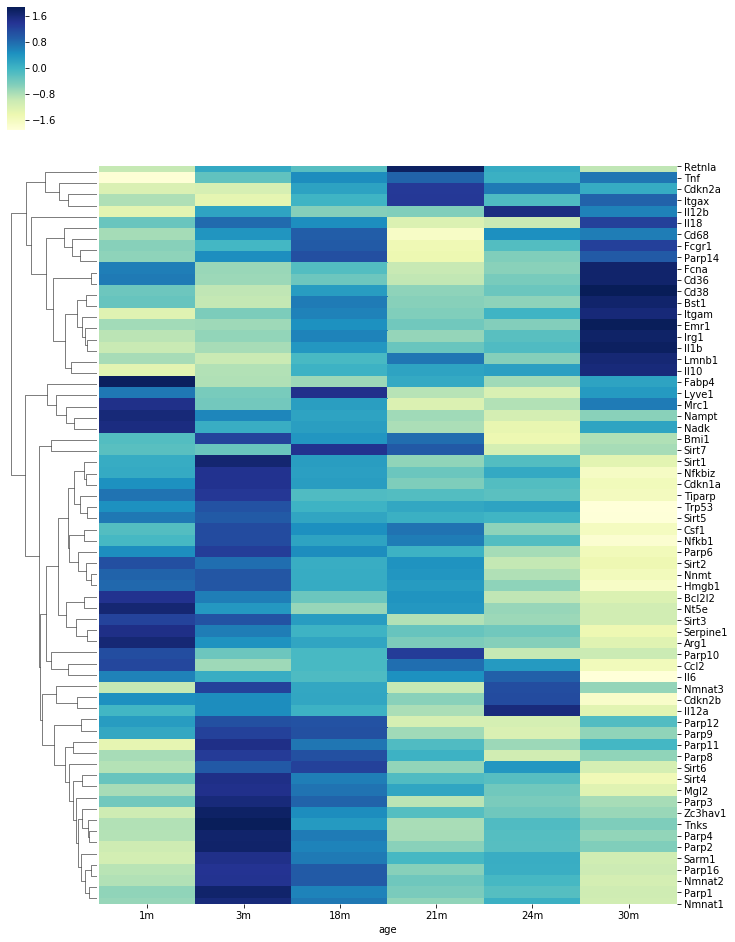

In [305]:
df = senescence_fractions.copy()
df = df.transpose()
# df = np.log(df)
# ax = sns.heatmap(df, cmap="YlGnBu")
clustermap = sns.clustermap(df, cmap="YlGnBu", yticklabels=True,
               figsize=(12,(.25*(len(df.index)))),
#                standard_scale=0,
               col_cluster=False, 
               z_score=0
              )
plt.savefig('senescence_fractions.pdf')

In [311]:
df.index[clustermap.dendrogram_row.reordered_ind]

Index(['Retnla', 'Tnf', 'Cdkn2a', 'Itgax', 'Il12b', 'Il18', 'Cd68', 'Fcgr1',
       'Parp14', 'Fcna', 'Cd36', 'Cd38', 'Bst1', 'Itgam', 'Emr1', 'Irg1',
       'Il1b', 'Lmnb1', 'Il10', 'Fabp4', 'Lyve1', 'Mrc1', 'Nampt', 'Nadk',
       'Bmi1', 'Sirt7', 'Sirt1', 'Nfkbiz', 'Cdkn1a', 'Tiparp', 'Trp53',
       'Sirt5', 'Csf1', 'Nfkb1', 'Parp6', 'Sirt2', 'Nnmt', 'Hmgb1', 'Bcl2l2',
       'Nt5e', 'Sirt3', 'Serpine1', 'Arg1', 'Parp10', 'Ccl2', 'Il6', 'Nmnat3',
       'Cdkn2b', 'Il12a', 'Parp12', 'Parp9', 'Parp11', 'Parp8', 'Sirt6',
       'Sirt4', 'Mgl2', 'Parp3', 'Zc3hav1', 'Tnks', 'Parp4', 'Parp2', 'Sarm1',
       'Parp16', 'Nmnat2', 'Parp1', 'Nmnat1'],
      dtype='object')

In [312]:
senescence_high = ['Retnla', 'Tnf', 'Cdkn2a', 'Itgax', 'Il12b', 'Il18', 'Cd68', 'Fcgr1',
       'Parp14', 'Fcna', 'Cd36', 'Cd38', 'Bst1', 'Itgam', 'Emr1', 'Irg1',
       'Il1b', 'Lmnb1', 'Il10', 'Fabp4', 'Lyve1', 'Mrc1', 'Nampt', 'Nadk',
       'Bmi1', 'Sirt7']
senescence_low = ['Sirt1', 'Nfkbiz', 'Cdkn1a', 'Tiparp', 'Trp53',
       'Sirt5', 'Csf1', 'Nfkb1', 'Parp6', 'Sirt2', 'Nnmt', 'Hmgb1', 'Bcl2l2',
       'Nt5e', 'Sirt3', 'Serpine1', 'Arg1', 'Parp10', 'Ccl2', 'Il6', 'Nmnat3',
       'Cdkn2b', 'Il12a', 'Parp12', 'Parp9', 'Parp11', 'Parp8', 'Sirt6',
       'Sirt4', 'Mgl2', 'Parp3', 'Zc3hav1', 'Tnks', 'Parp4', 'Parp2', 'Sarm1',
       'Parp16', 'Nmnat2', 'Parp1', 'Nmnat1']



In [ ]:
senescence_adata
sc.tl.score_genes(senescence_adata,senescence_high, score_name='score_senescence_high')
sc.tl.score_genes(senescence_adata,senescence_low, score_name='score_senescence_low')

In [450]:
sc.tl.score_genes(senescence_adata,senescence_high+senescence_low, score_name='score_senescence')

computing score 'score_senescence'
    finished (0:00:51.23) --> added
    'score_senescence', score of gene set (adata.obs)


In [318]:
senescence_adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'score_senescence_high', 'score_senescence_low'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

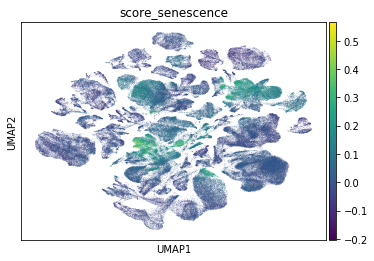

In [497]:
sc.pl.umap(senescence_adata,color='score_senescence')

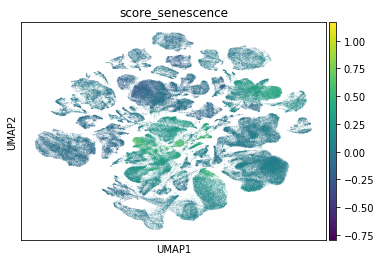

In [320]:
senescence_adata.obs['score_senescence'] = senescence_adata.obs['score_senescence_high'] - senescence_adata.obs['score_senescence_low']

sc.pl.umap(senescence_adata,color='score_senescence')

In [361]:
senescence_adata_score

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi,tint,score_senescence_high,score_senescence_low,score_senescence
AAACCTGCAGGGTACA-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,5482.0,2107.0,male,nan,Tongue,Tongue,1,23,-0.089218,0.020960,-0.110178
AAACCTGCAGTAAGCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,21855.0,3481.0,male,nan,Tongue,Tongue,1,23,-0.121560,-0.040466,-0.081094
AAACCTGTCATTATCC-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,10942.0,2599.0,male,nan,Tongue,Tongue,1,23,-0.131503,-0.058894,-0.072609
AAACGGGGTACAGTGG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,20665.0,3468.0,male,nan,Tongue,Tongue,1,23,-0.075577,0.038174,-0.113750
AAACGGGGTCTTCTCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,12925.0,3189.0,male,nan,Tongue,Tongue,1,23,-0.010246,-0.041661,0.031415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_MAA001690_S20.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_54_F,146918.0,3523.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,-0.122903,0.099368,-0.222271
P8_MAA001700_S104.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,1027448.0,4476.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,-0.147743,0.014528,-0.162271
P9_B000485_S69.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_47_F,1184028.0,2980.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,-0.142727,0.019497,-0.162224
P9_B000492_S153.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_46_F,771112.0,2595.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,-0.096982,0.112295,-0.209277


/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if __name__ == '__main__':


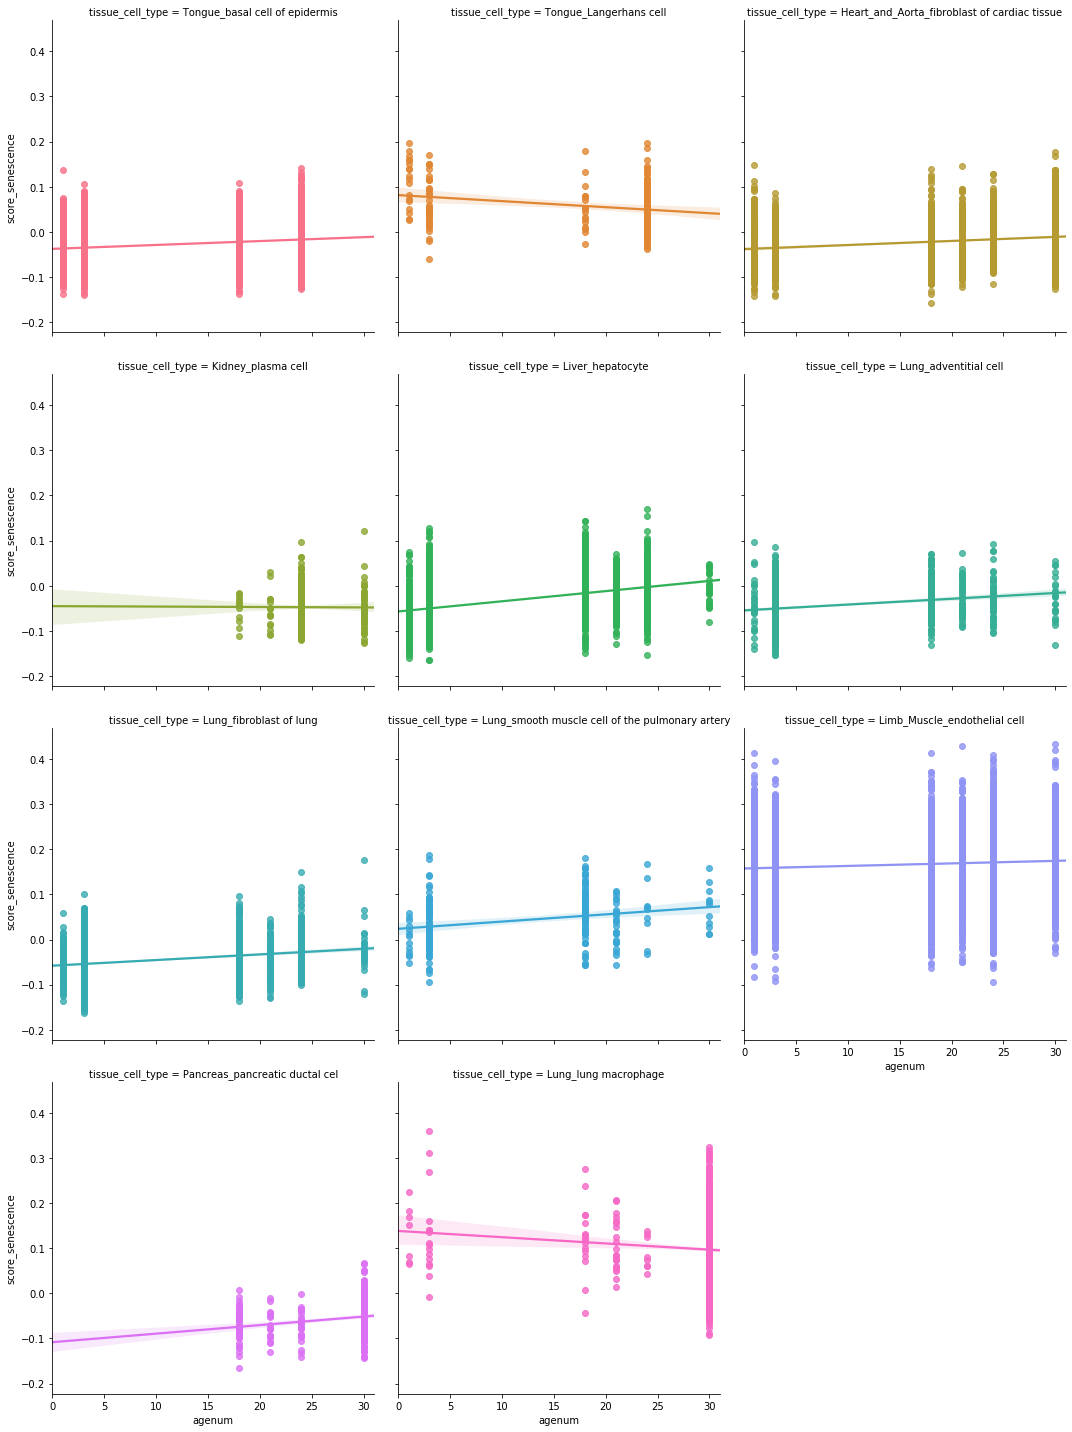

In [478]:
from scipy.stats import linregress

senescence_adata_score = senescence_adata.obs.copy()
senescence_adata_score['agenum'] = [np.float(a.split('m')[0]) for a in senescence_adata_score['age']]
senescence_adata_score['age'] = senescence_adata_score['age'].astype(str)
senescence_adata_score['tissue'] = senescence_adata_score['tissue'].astype(str)
senescence_adata_score['cell_ontology_class'] = senescence_adata_score['cell_ontology_class'].astype(str)
senescence_adata_score['tissue_cell_type'] = senescence_adata_score['tissue']+'_'+senescence_adata_score['cell_ontology_class']
senescence_adata_score = senescence_adata_score.groupby(['agenum','tissue_cell_type'])['score_senescence'].agg({'mean_score':np.mean})
senescence_adata_score = senescence_adata_score.reset_index()
# senescence_adata_score = senescence_adata_score.sort_values(by='mean_score')
senescence_adata_score

senescence_adata_score = pd.pivot_table(
    senescence_adata_score, values='mean_score', columns=['tissue_cell_type'],index=['agenum'])#, aggfunc=np.sum)
senescence_adata_score = senescence_adata_score.fillna(0)
senescence_adata_score

df = pd.DataFrame(index= senescence_adata_score.columns, columns=['m','r2','pval','std'])
for c in senescence_adata_score.columns:
    stats = linregress(senescence_adata_score.index,senescence_adata_score[c])
    m = stats.slope
    b = stats.intercept
    r2 = stats.rvalue
    pval = stats.pvalue
    std_err = stats.stderr

    df.loc[c,'m'] = m
    df.loc[c,'std'] = std_err
    df.loc[c,'pval'] = pval
    df.loc[c,'r2'] = r2**2
    
df

senescence_adata_score = senescence_adata.obs.copy()
senescence_adata_score['agenum'] = [np.float(a.split('m')[0]) for a in senescence_adata_score['age']]
senescence_adata_score['age'] = senescence_adata_score['age'].astype(str)
senescence_adata_score['tissue'] = senescence_adata_score['tissue'].astype(str)
senescence_adata_score['cell_ontology_class'] = senescence_adata_score['cell_ontology_class'].astype(str)
senescence_adata_score['tissue_cell_type'] = senescence_adata_score['tissue']+'_'+senescence_adata_score['cell_ontology_class']
# senescence_adata_score = senescence_adata_score.groupby(['agenum','cell_ontology_class'])['score_senescence'].agg({'mean_score':np.median})
senescence_adata_score = senescence_adata_score.reset_index()
# senescence_adata_score = senescence_adata_score.sort_values(by='mean_score')
senescence_adata_score

senescence_adata_score = senescence_adata_score.loc[senescence_adata_score['tissue_cell_type'].isin(
    list(df.loc[df['pval']<.05].index.values))]

lm = sns.lmplot(x="agenum", col = 'tissue_cell_type', col_wrap=3,
           y="score_senescence", hue="tissue_cell_type", data=senescence_adata_score,
           fit_reg=True)#,
#            palette=tissue_color_dict)
axes = lm.axes

for i in range(len(axes)):
    axes[i].set_xlim(0,31)

# # # senescence_adata_score['age'] = senescence_adata_score['age'].astype(str)
# # senescence_adata_score['tissue'] = senescence_adata_score['tissue'].astype(str)
# # senescence_adata_score['cell_ontology_class'] = senescence_adata_score['cell_ontology_class'].astype(str)
# # senescence_adata_score = senescence_adata_score.groupby(['age','cell_ontology_class'])['score_senescence'].agg({'mean_score':np.median})
# # senescence_adata_score = senescence_adata_score.reset_index()
# # senescence_adata_score = senescence_adata_score.sort_values(by='mean_score')

# # senescence_adata_score = pd.pivot_table(
# #     senescence_adata_score, values='mean_score', index=['cell_ontology_class'],columns=['age'])#, aggfunc=np.sum)
# # senescence_adata_score = senescence_adata_score.fillna(0)

# # senescence_adata_score

# # clustermap = sns.clustermap(senescence_adata_score, cmap="YlGnBu", yticklabels=True,
# #                figsize=(15,(.45*(len(df.index)))),
# # #                standard_scale=0,
# #                col_cluster=False, 
# # #                z_score=0
# #               )

plt.tight_layout()
plt.savefig('senescence_score.pdf')



In [479]:
df.loc[df['pval']<.05]

,m,r2,pval,std
tissue_cell_type,,,,
Heart_and_Aorta_fibroblast of cardiac tissue,0.000913132,0.785773,0.0186121,0.000238392
Kidney_plasma cell,-0.00207949,0.844031,0.00964313,0.000446958
Limb_Muscle_endothelial cell,0.000557719,0.764271,0.0227339,0.000154871
Liver_hepatocyte,0.00181969,0.754634,0.0247289,0.000518807
Lung_adventitial cell,0.000798482,0.749746,0.0257766,0.000230658
Lung_fibroblast of lung,0.00112222,0.766822,0.0222213,0.000309419
Lung_lung macrophage,-0.00152992,0.840948,0.01004,0.000332679
Lung_smooth muscle cell of the pulmonary artery,0.00186372,0.724737,0.0315173,0.000574293
Pancreas_pancreatic ductal cel,-0.00257193,0.718962,0.0329354,0.000804006


In [470]:
list(df.loc[df['pval']<.1].index.values)

['Bladder_bladder urothelial cell',
 'Heart_and_Aorta_endocardial cell',
 'Heart_and_Aorta_fibroblast of cardiac tissue',
 'Heart_and_Aorta_smooth muscle cell',
 'Kidney_plasma cell',
 'Limb_Muscle_endothelial cell',
 'Limb_Muscle_mesenchymal stem cell',
 'Limb_Muscle_smooth muscle cell',
 'Liver_Kupffer cell',
 'Liver_endothelial cell of hepatic sinusoid',
 'Liver_hepatocyte',
 'Lung_CD4-positive, alpha-beta T cell',
 'Lung_adventitial cell',
 'Lung_fibroblast of lung',
 'Lung_lung macrophage',
 'Lung_smooth muscle cell of the pulmonary artery',
 'Pancreas_pancreatic ductal cel',
 'Spleen_granulocyte',
 'Spleen_macrophage dendritic cell progenitor',
 'Spleen_mature NK T cell',
 'Spleen_proerythroblast',
 'Tongue_Langerhans cell',
 'Tongue_basal cell of epidermis',
 'Tongue_keratinocyte']

In [459]:
df['r2']

tissue_cell_type
Aorta_aortic endothelial cell            0.00691085
Aorta_epithelial cell                     0.0242052
Aorta_fibroblast of cardiac tissue         0.120433
Aorta_fibrocyte                          0.00532359
Aorta_macrophage                          0.0224917
                                            ...    
Trachea_mesenchymal cell                   0.304662
Trachea_mesenchymal progenitor cell        0.304662
Trachea_mucus secreting cell               0.105088
Trachea_neuroendocrine cell                0.304662
Trachea_smooth muscle cell of trachea     0.0696116
Name: r2, Length: 280, dtype: object

In [431]:
senescence_adata_score = senescence_adata.obs.copy()
senescence_adata_score['agenum'] = [np.float(a.split('m')[0]) for a in senescence_adata_score['age']]
senescence_adata_score['age'] = senescence_adata_score['age'].astype(str)
senescence_adata_score['tissue'] = senescence_adata_score['tissue'].astype(str)
senescence_adata_score['cell_ontology_class'] = senescence_adata_score['cell_ontology_class'].astype(str)
# senescence_adata_score = senescence_adata_score.groupby(['agenum','cell_ontology_class'])['score_senescence'].agg({'mean_score':np.median})
senescence_adata_score = senescence_adata_score.reset_index()
# senescence_adata_score = senescence_adata_score.sort_values(by='mean_score')
senescence_adata_score

senescence_adata_score = senescence_adata_score.loc[senescence_adata_score['cell_ontology_class'].isin(
    list(df.loc[df['r2']>.4].index.values))]
senescence_adata_score


,index,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,...,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi,tint,score_senescence_high,score_senescence_low,score_senescence,agenum
2057,AAACCTGGTAGTAGTA-1-2-0-0-0,18m,0,MACA_18m_F_BM_50_AAACCTGGTAGTAGTA,naive T cell,NA,nan,droplet,18-F-50,19087.0,...,female,nan,Marrow,Marrow,14,17,-0.034796,-0.042525,0.007730,18.0
2058,AAACGGGCATCGTCGG-1-2-0-0-0,18m,0,MACA_18m_F_BM_50_AAACGGGCATCGTCGG,hematopoietic precursor cell,NA,nan,droplet,18-F-50,10093.0,...,female,nan,Marrow,Marrow,17,17,-0.074041,-0.032409,-0.041632,18.0
2060,AAAGATGGTGACTACT-1-2-0-0-0,18m,0,MACA_18m_F_BM_50_AAAGATGGTGACTACT,megakaryocyte-erythroid progenitor cell,NA,nan,droplet,18-F-50,8718.0,...,female,nan,Marrow,Marrow,14,17,-0.028393,-0.081172,0.052779,18.0
2063,AAAGCAACAATGTAAG-1-2-0-0-0,18m,0,MACA_18m_F_BM_50_AAAGCAACAATGTAAG,megakaryocyte-erythroid progenitor cell,NA,nan,droplet,18-F-50,10067.0,...,female,nan,Marrow,Marrow,14,17,-0.008355,-0.053389,0.045034,18.0
2068,AAAGTAGCATACAGCT-1-2-0-0-0,18m,0,MACA_18m_F_BM_50_AAAGTAGCATACAGCT,hematopoietic precursor cell,NA,nan,droplet,18-F-50,8158.0,...,female,nan,Marrow,Marrow,17,17,-0.026691,0.033302,-0.059993,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355932,M2_MAA001700_S26.mus-2-1-1,21m,1,nan,endothelial cell,NA,nan,facs,21_55_F,1048858.0,...,female,Mammary_Gland,Mammary_Gland,nan,3,16,0.089331,0.047252,0.042079,21.0
355992,N17_B000485_S29.mus-2-1-1,18m,1,nan,endothelial cell,NA,nan,facs,18_47_F,356820.0,...,female,Mammary_Gland,Mammary_Gland,nan,3,16,0.122921,-0.011331,0.134252,18.0
356019,N2_B000485_S14.mus-2-1-1,18m,1,nan,endothelial cell,NA,nan,facs,18_47_F,893608.0,...,female,Mammary_Gland,Mammary_Gland,nan,3,16,0.048950,0.157103,-0.108153,18.0
356097,O20_B000492_S140.mus-2-1-1,18m,1,nan,endothelial cell,NA,nan,facs,18_46_F,340325.0,...,female,Mammary_Gland,Mammary_Gland,nan,31,16,0.220656,0.065327,0.155329,18.0


In [424]:
list(df.loc[df['r2']>.4].index.values)

['Kupffer cell',
 'Langerhans cell',
 'adventitial cell',
 'bladder urothelial cell',
 'cardiac neuron',
 'endothelial cell',
 'hematopoietic precursor cell',
 'hepatocyte',
 'keratinocyte',
 'late pro-B cell',
 'mast cell',
 'megakaryocyte-erythroid progenitor cell',
 'myeloid dendritic cell',
 'myeloid leukocyte',
 'naive T cell',
 'pancreatic ductal cel',
 'plasma cell',
 'podocyte',
 'regulatory T cell']

In [428]:
senescence_adata_score.loc[senescence_adata_score['cell_ontology_class'].isin(list(df.loc[df['r2']>.4].index.values))]

,agenum,cell_ontology_class,mean_score
3,1.0,Kupffer cell,0.444883
8,1.0,adventitial cell,-0.065330
23,1.0,endothelial cell,0.142468
37,1.0,hematopoietic precursor cell,-0.021943
39,1.0,hepatocyte,-0.004511
...,...,...,...
674,30.0,myeloid dendritic cell,0.145672
675,30.0,myeloid leukocyte,0.262329
677,30.0,naive T cell,0.005331
688,30.0,plasma cell,0.060760


ranking genes


/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small va

/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:387: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/l

    finished (0:38:03.34) --> added to `.uns['rank_genes_groups_wilcox']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


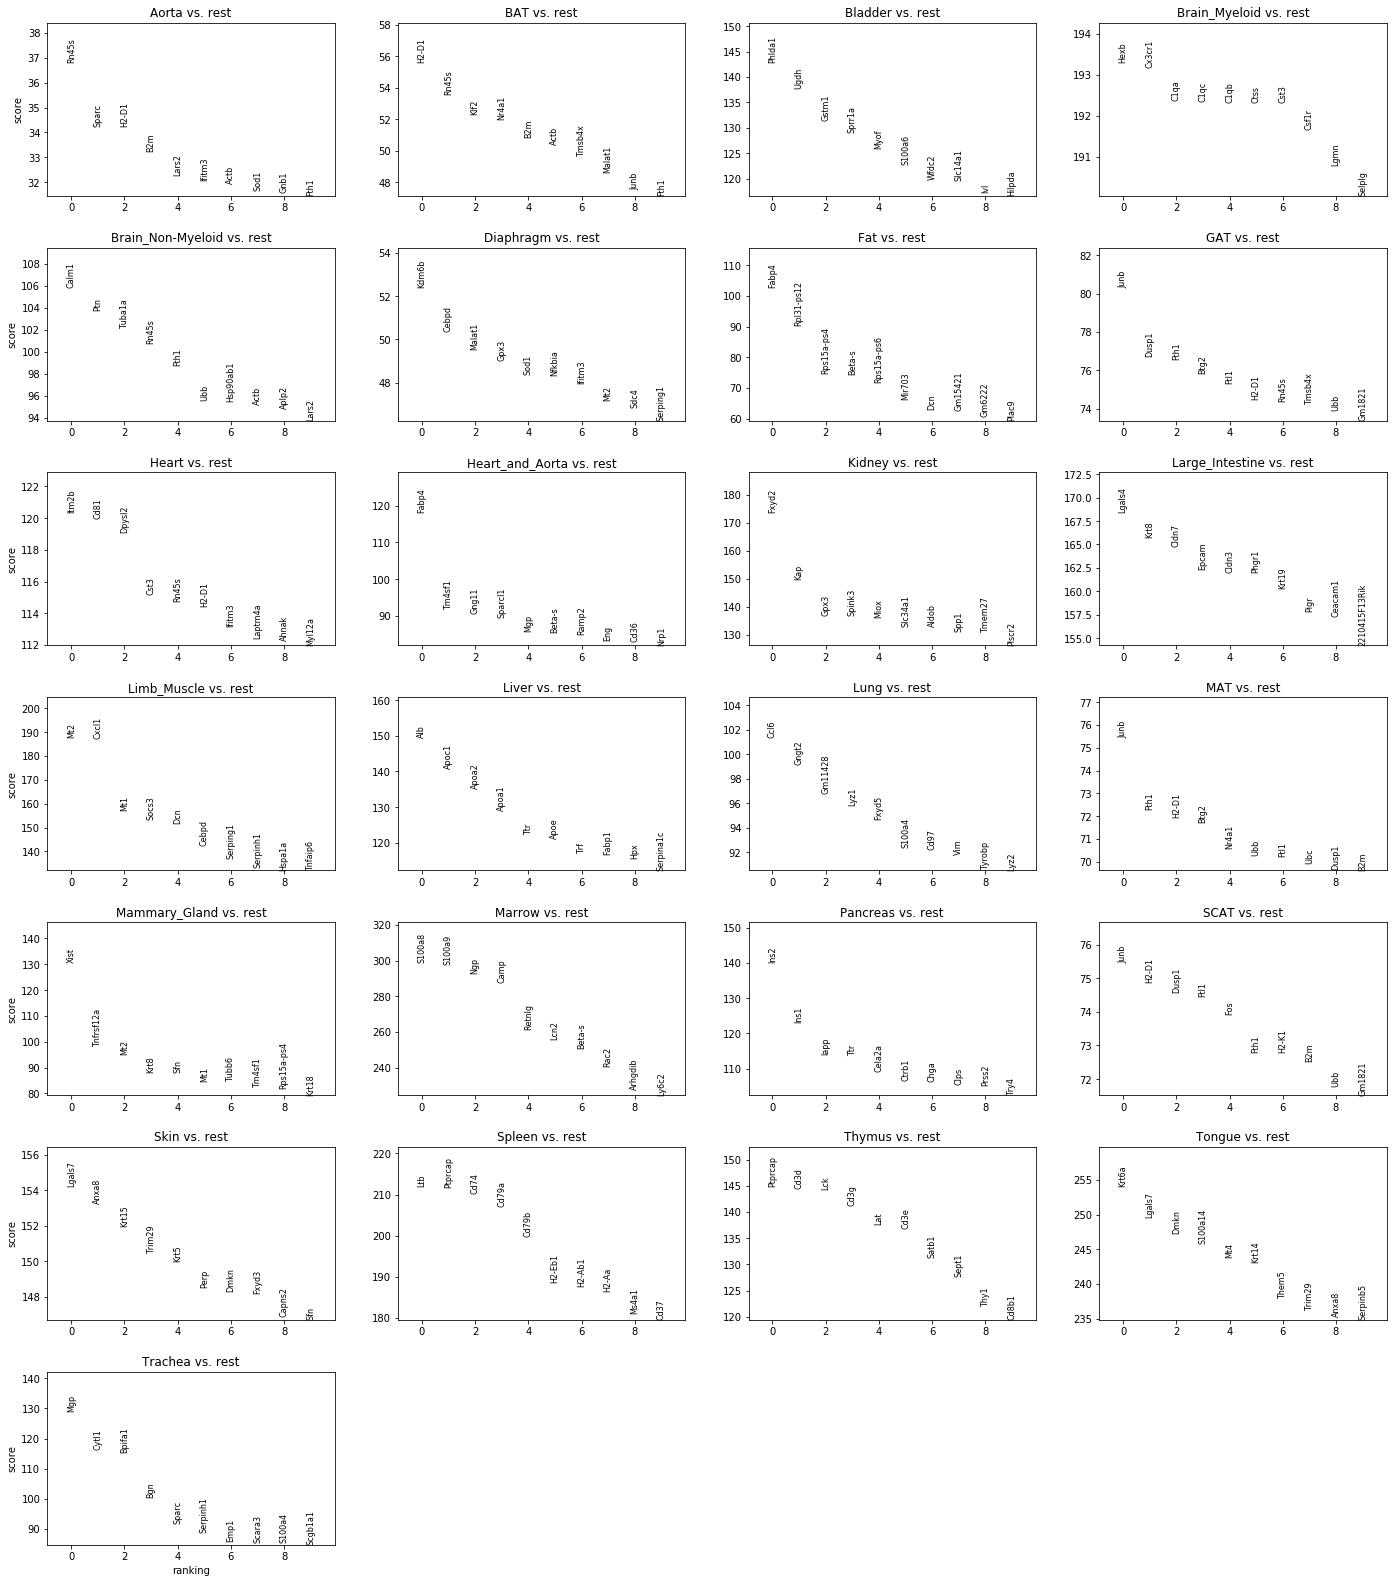

In [59]:
sc.tl.rank_genes_groups(
    adata,
    "tissue",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=n_genes,
)

sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False, n_genes=n_genes)

In [61]:
for 

{'params': {'groupby': 'tissue',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'corr_method': 'benjamini-hochberg'},
 'scores': rec.array([(36.805714, 55.58487 , 142.81622, 193.29666, 105.858475, 52.40335 , 102.782326, 80.32646 , 120.365746, 118.198135, 173.77518, 168.42728, 187.84929, 149.58717 , 101.376724, 75.46148 , 130.87517 , 299.21393, 140.26834 , 75.47957 , 154.18417, 211.85538, 144.79495 , 253.98233, 128.92015 ),
            (34.245636, 53.580322, 137.71951, 193.17859, 103.7985  , 50.371387,  90.47592 , 76.74093 , 119.99034 ,  91.79842 , 149.68015, 165.74615, 187.34769, 140.79211 ,  99.17016 , 72.26872 ,  98.28891 , 297.9586 , 123.169426, 74.86139 , 153.23795, 211.61435, 144.52197 , 249.59795, 116.32902 ),
            (34.219055, 52.309917, 131.46078, 192.37354, 102.09886 , 49.54865 ,  74.83576 , 76.547035, 119.08879 ,  90.586624, 137.10951, 164.76602, 157.1439 , 135.14378 ,  96.7549  , 71.93267 ,  94.867355, 292.79468, 113.95158 , 74.56098 , 151.93709, 

In [63]:
result = adata.uns['rank_genes_groups_wilcox']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,Aorta_n,Aorta_s,BAT_n,BAT_s,Bladder_n,Bladder_s,Brain_Myeloid_n,Brain_Myeloid_s,Brain_Non-Myeloid_n,Brain_Non-Myeloid_s,...,Skin_n,Skin_s,Spleen_n,Spleen_s,Thymus_n,Thymus_s,Tongue_n,Tongue_s,Trachea_n,Trachea_s
0,Rn45s,36.805714,H2-D1,55.584869,Phlda1,142.816223,Hexb,193.296661,Calm1,105.858475,...,Lgals7,154.184174,Ltb,211.855377,Ptprcap,144.794952,Krt6a,253.982330,Mgp,128.920151
1,Sparc,34.245636,Rn45s,53.580322,Ugdh,137.719513,Cx3cr1,193.178589,Ptn,103.798500,...,Anxa8,153.237946,Ptprcap,211.614349,Cd3d,144.521973,Lgals7,249.597946,Cytl1,116.329018
2,H2-D1,34.219055,Klf2,52.309917,Gstm1,131.460785,C1qa,192.373535,Tuba1a,102.098862,...,Krt15,151.937088,Cd74,210.275772,Lck,144.234863,Dmkn,247.267975,Bpifa1,115.245857
3,B2m,33.216743,Nr4a1,51.971672,Sprr1a,129.047073,C1qc,192.355453,Rn45s,100.718895,...,Trim29,150.446320,Cd79a,207.112549,Cd3g,141.172852,S100a14,245.750671,Bgn,100.574371
4,Lars2,32.246983,B2m,50.828629,Myof,125.983078,C1qb,192.332809,Fth1,98.753029,...,Krt5,149.989441,Cd79b,199.702209,Lat,137.556259,Mt4,243.788696,Sparc,91.912598


In [62]:
result = adata.uns['rank_genes_groups_scvi']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,...,20_n,20_s,21_n,21_s,22_n,22_s,23_n,23_s,24_n,24_s
0,G630055G22RIK,2.081581,KLF2,1.363944,MYOF,3.307934,HEXB,5.234733,MBP,3.813225,...,AADACL3,5.313606,LTB,2.519535,LCK,2.944439,THEM5,5.710525,GM15698,2.646582
1,RGS5,2.005755,OASL1,1.272673,1110059M19RIK,3.119747,P2RY12,5.093346,ZIC3,3.476098,...,9130204L05RIK,5.126884,DEFB6,2.372422,SIT1,2.838094,LYG1,5.595713,CYTL1,2.522439
2,FABP4,1.986760,CREM,1.266249,NPY5R,2.972150,4930556J02RIK,4.783164,GPR37L1,3.122219,...,CALM5,5.029430,FFAR1,2.271630,SKAP1,2.794907,OTOP2,5.399166,1700016G22RIK,2.416807
3,ZFP366,1.974559,SLC24A1,1.217935,LOC627800,2.955015,LGMN,4.783164,S100B,3.050405,...,SERPINA3H,5.014062,PTPRCAP,2.265744,CD8A,2.783907,PAX9,5.293303,5930438M14,2.414150
4,UNC45B,1.966178,ISG15,1.182517,GSTM1,2.946546,LPCAT2,4.701489,2610017I09RIK,3.043475,...,CCL27A,4.820281,GIMAP7,2.259887,LAT,2.742704,PITX1,5.179371,LIF,2.394409


In [131]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain', 'leiden', 'tissue_FACS_droplet'
    var: 'n_cells-0', 'n_cells-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'leiden', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [132]:
pd.crosstab(adata.obs['age'],adata.obs['method'])

method,droplet,facs
age,,
18m,44645,34027
1m,25980,0
21m,35828,728
24m,37660,31551
30m,55674,0
3m,45602,44518
